In [ ]:
import pandas as pd
import regex as re


def clean_queries(series):
    cleaned = series.str.replace(
        r'\s+\d{4}-\d{2}-\d{2}\s+\d{2}:\d{2}:\d{2}\s*|\n',
        ' ',
        regex=True
    ).str.replace(r'\s+', ' ', regex=True).str.strip()
    
    return cleaned

df = pd.read_csv('sample_data.txt',
                 sep='\0',
                 header=0,
                 names=['value'],
                 engine='c',
                 dtype=str,
                 na_filter=False)

df['query'] = clean_queries(df['value'])
df = df.drop('value', axis=1)

df = df[df['query'] != ''].copy()
df.head(10), df.size

: 

In [229]:
# Preprocessing: sentence split, tokenization, filtering, stemming (EN + RU)
# Dependencies and configuration
import sys, subprocess, random, math, itertools
from pathlib import Path
from collections import Counter, defaultdict

# Optional lightweight installer for missing libs (works in most notebook envs)
def ensure(pkg, import_name=None):
    name = import_name or pkg
    try:
        __import__(name)
    except Exception:
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "--quiet", pkg])
        except Exception:
            pass  # If install is blocked, user can install manually

# Core deps
ensure("regex")
ensure("networkx")
ensure("matplotlib")
ensure("nltk")
# Optional
ensure("python-louvain", "community")
# ensure("pyvis")  # enable if you want interactive viz

import networkx as nx
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer, RussianStemmer

# Prepare NLTK resources
try:
    _ = stopwords.words("english")
    _ = stopwords.words("russian")
except LookupError:
    nltk.download("stopwords")

STOP_EN = set(stopwords.words("english"))
STOP_RU = set(stopwords.words("russian"))
STEM_EN = EnglishStemmer()
STEM_RU = RussianStemmer()

def is_cyrillic(token: str) -> bool:
    return bool(re.search(r"\p{IsCyrillic}", token))


def normalize_token(token: str) -> str:
    if is_cyrillic(token):
        return STEM_RU.stem(token)
    return STEM_EN.stem(token)


def tokenize_to_sentences(text: str):
    # split to sentences by punctuation; keep it simple for speed
    for sent in re.split(r"[.!?]+", text):
        sent = sent.strip()
        if not sent:
            continue
        # Unicode letters only
        tokens = [t.lower() for t in re.findall(r"\p{L}+", sent)]
        # filter stopwords by script
        filtered = []
        for t in tokens:
            if len(t) < 2:
                continue
            if is_cyrillic(t):
                if t in STOP_RU:
                    continue
            else:
                if t in STOP_EN:
                    continue
            filtered.append(normalize_token(t))
        if filtered:
            yield filtered

sentences_tokens = []
for text in df["query"].astype(str).tolist():
    sentences_tokens.extend(list(tokenize_to_sentences(text)))

print(f"Prepared {len(sentences_tokens):,} tokenized sentences")

sentences_tokens[:3]

Prepared 9,922,942 tokenized sentences


[['datakam'], ['yuxuda', 'kız', 'usagi', 'gormek'], ['порн']]

In [230]:
# Build co-occurrence with sliding window K
cooccur = Counter()
unigram = Counter()

for sent in sentences_tokens:
    n = len(sent)
    for i in range(n):
        w_i = sent[i]
        unigram[w_i] += 1
        j_end = min(n, i + K + 1)
        for j in range(i + 1, j_end):
            w_j = sent[j]
            if w_i == w_j:
                continue
            a, b = (w_i, w_j) if w_i < w_j else (w_j, w_i)
            cooccur[(a, b)] += 1

print(f"Unigrams: {len(unigram):,}; Co-occurring pairs: {len(cooccur):,}")
# show a few samples
list(itertools.islice(cooccur.items(), 5))

Unigrams: 964,279; Co-occurring pairs: 12,438,288


[(('kız', 'yuxuda'), 1),
 (('usagi', 'yuxuda'), 1),
 (('gormek', 'yuxuda'), 4),
 (('kız', 'usagi'), 1),
 (('gormek', 'kız'), 1)]

In [ ]:
# Parameters
K = 3  # sliding window size for co-occurrence
MIN_COOCC = 20
MIN_PPMI = 0.5
MIN_DEGREE = 5
TOP_N_CLUSTERS = 100
RANDOM_STATE = 42

plt.rcParams["figure.figsize"] = (10, 8)

print("Config ready:", {"K": K, "MIN_COOCC": MIN_COOCC, "MIN_PPMI": MIN_PPMI, "MIN_DEGREE": MIN_DEGREE, "TOP_N_CLUSTERS": TOP_N_CLUSTERS})

Config ready: {'K': 3, 'MIN_COOCC': 20, 'MIN_PPMI': 0.5, 'MIN_DEGREE': 5, 'TOP_N_CLUSTERS': 100}


In [358]:
# Compute PPMI and threshold edges
num_tokens = sum(unigram.values())
num_pairs = sum(cooccur.values())

ppmi = {}

for (w1, w2), c12 in cooccur.items():
    if c12 < MIN_COOCC:
        continue
    p12 = c12 / num_pairs if num_pairs else 0.0
    p1 = unigram[w1] / num_tokens if num_tokens else 0.0
    p2 = unigram[w2] / num_tokens if num_tokens else 0.0
    denom = (p1 * p2) if (p1 and p2) else 0.0
    score = 0.0
    if denom > 0 and p12 > 0:
        score = max(0.0, math.log2(p12 / denom))
    if score >= MIN_PPMI:
        ppmi[(w1, w2)] = score

print(f"PPMI edges kept: {len(ppmi):,} (of {len(cooccur):,})")
list(itertools.islice(ppmi.items(), 5))


PPMI edges kept: 214,486 (of 12,438,288)


[(('наход', 'сосуд'), 6.0347398795118705),
 (('газ', 'наход'), 2.880386957702251),
 (('панел', 'управлен'), 6.365082532795475),
 (('машин', 'управлен'), 2.4451449762243294),
 (('машин', 'стиральн'), 9.34906538027584)]

In [359]:
# Build graph and prune low-degree nodes
G = nx.Graph()

# add nodes with frequency attribute
for w, f in unigram.items():
    G.add_node(w, freq=f)

# add edges with attributes
for (w1, w2), score in ppmi.items():
    count = cooccur.get((w1, w2), 0)
    if count >= MIN_COOCC:
        G.add_edge(w1, w2, weight=count, ppmi=score)

print(f"Graph before pruning: |V|={G.number_of_nodes():,}, |E|={G.number_of_edges():,}")

# prune by degree
low_deg = [n for n, d in G.degree() if d < MIN_DEGREE]
G.remove_nodes_from(low_deg)

# remove isolated
isolates = list(nx.isolates(G))
G.remove_nodes_from(isolates)

print(f"Graph after pruning:  |V|={G.number_of_nodes():,}, |E|={G.number_of_edges():,}")


Graph before pruning: |V|=964,279, |E|=214,486
Graph after pruning:  |V|=10,284, |E|=182,598


In [360]:
# Community detection (Louvain preferred)
try:
    import community as community_louvain
    partition = community_louvain.best_partition(G, weight="ppmi", random_state=RANDOM_STATE)
    algo = "louvain"
except Exception:
    # Fallback: greedy modularity communities
    comms = list(nx.algorithms.community.greedy_modularity_communities(G, weight="ppmi"))
    partition = {}
    for cid, nodes in enumerate(comms):
        for n in nodes:
            partition[n] = cid
    algo = "greedy_modularity"

nx.set_node_attributes(G, partition, "cluster")
num_clusters = len(set(partition.values())) if partition else 0
print(f"Communities found: {num_clusters} (algo={algo})")

# Modularity (if possible)
try:
    import community as community_louvain
    Q = community_louvain.modularity(partition, G, weight="ppmi")
    print(f"Modularity: {Q:.4f}")
except Exception:
    try:
        from networkx.algorithms.community.quality import modularity
        Q = modularity(G, [ {n for n,c in partition.items() if c==cid} for cid in set(partition.values()) ], weight="ppmi")
        print(f"Modularity: {Q:.4f}")
    except Exception:
        print("Modularity: n/a")


Communities found: 13 (algo=louvain)
Modularity: 0.4675


In [361]:
RESOLUTION = 100    # >1 → more, smaller communities
BACKBONE_ALPHA = 0.075
K_CORE_K = 1
print({"MIN_COOCC":MIN_COOCC, "MIN_PPMI":MIN_PPMI, "MIN_DEGREE":MIN_DEGREE, "RESOLUTION":RESOLUTION, "BACKBONE_ALPHA":BACKBONE_ALPHA, "K_CORE_K":K_CORE_K})


{'MIN_COOCC': 20, 'MIN_PPMI': 0.5, 'MIN_DEGREE': 5, 'RESOLUTION': 100, 'BACKBONE_ALPHA': 0.075, 'K_CORE_K': 1}


In [362]:
# Disparity backbone filter (Serrano et al. 2009)
# Keeps edges significant for at least one endpoint (OR rule)

def disparity_backbone(G_in, weight="ppmi", alpha=0.05, mode="or"):
    G = G_in.copy()
    if G.number_of_edges() == 0:
        return G
    # compute strengths
    strength = {n: 0.0 for n in G.nodes()}
    for u, v, d in G.edges(data=True):
        w = float(d.get(weight, d.get("weight", 1.0)))
        strength[u] += w
        strength[v] += w
    keep_edges = []
    for u, v, d in G.edges(data=True):
        w = float(d.get(weight, d.get("weight", 1.0)))
        su = strength[u]
        sv = strength[v]
        ku = G.degree(u)
        kv = G.degree(v)
        if su <= 0 or sv <= 0:
            continue
        p_u = w / su
        p_v = w / sv
        # alpha = (1 - p)^(k-1)
        alpha_u = (1.0 - p_u) ** max(1, ku - 1)
        alpha_v = (1.0 - p_v) ** max(1, kv - 1)
        if mode == "and":
            ok = (alpha_u < alpha) and (alpha_v < alpha)
        else:
            ok = (alpha_u < alpha) or (alpha_v < alpha)
        if ok:
            keep_edges.append((u, v, d))
    H = nx.Graph()
    H.add_nodes_from(G.nodes(data=True))
    H.add_edges_from(keep_edges)
    return H

G_backbone = disparity_backbone(G, weight="ppmi", alpha=BACKBONE_ALPHA, mode="or")
print(f"Backbone: |V|={G_backbone.number_of_nodes():,}, |E|={G_backbone.number_of_edges():,}")


Backbone: |V|=10,284, |E|=833


In [363]:
# k-core pruning on backbone
if G_backbone.number_of_nodes() == 0:
    G_core = G_backbone
else:
    try:
        G_core = nx.k_core(G_backbone, k=K_CORE_K)
    except nx.NetworkXError:
        # if k too high, fallback to maximal core available
        core_numbers = nx.core_number(G_backbone)
        kmax = max(core_numbers.values()) if core_numbers else 0
        G_core = nx.k_core(G_backbone, k=kmax)

print(f"k-core graph: |V|={G_core.number_of_nodes():,}, |E|={G_core.number_of_edges():,}")
# show components sizes
components = sorted([len(c) for c in nx.connected_components(G_core)], reverse=True)
print("Largest components (sizes):", components[:10])


k-core graph: |V|=1,145, |E|=833
Largest components (sizes): [65, 30, 29, 29, 26, 18, 15, 15, 10, 9]


Core communities: 413 (algo=louvain, resolution=100)


/var/folders/lw/f0n2qlq93lbgl6jfwf_6z7980000gn/T/ipykernel_6339/2113499621.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = cm.get_cmap('tab20', len(unique_cids))


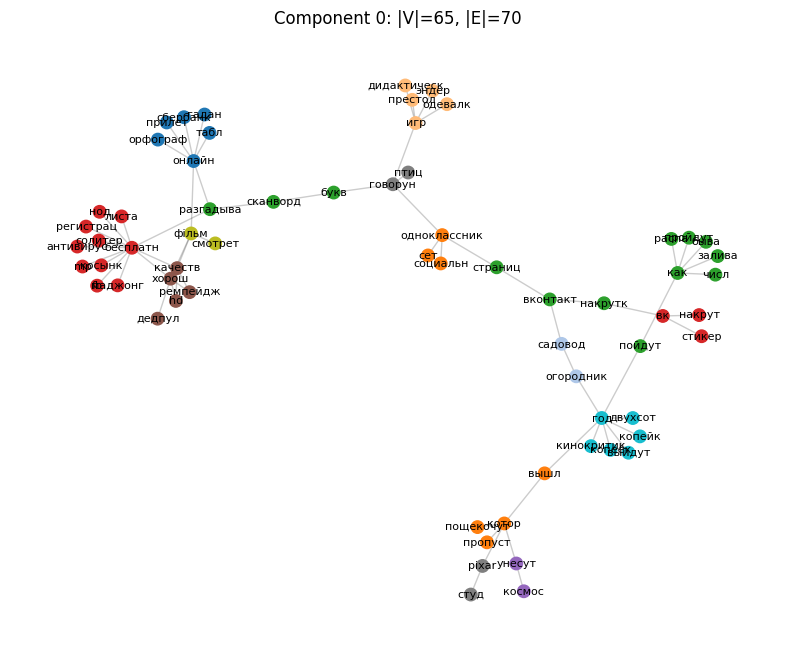

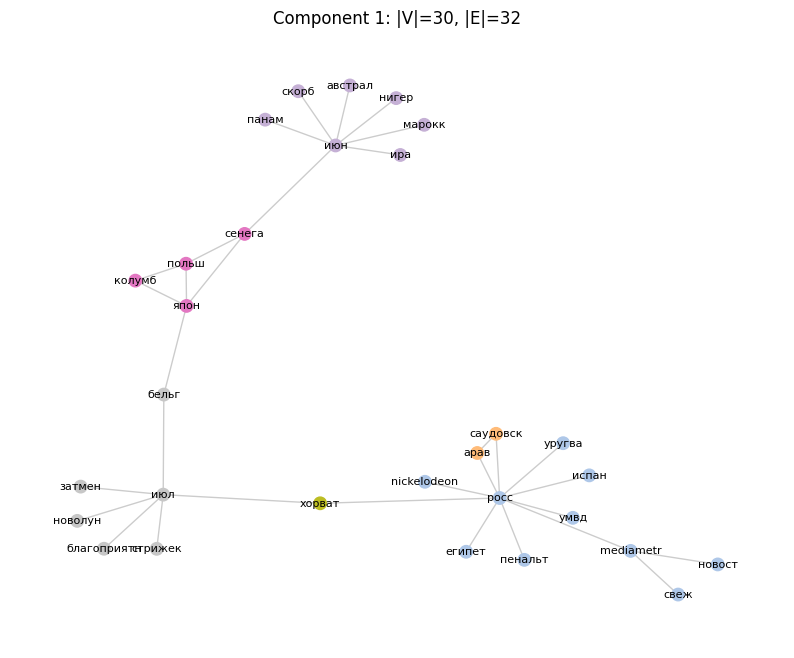

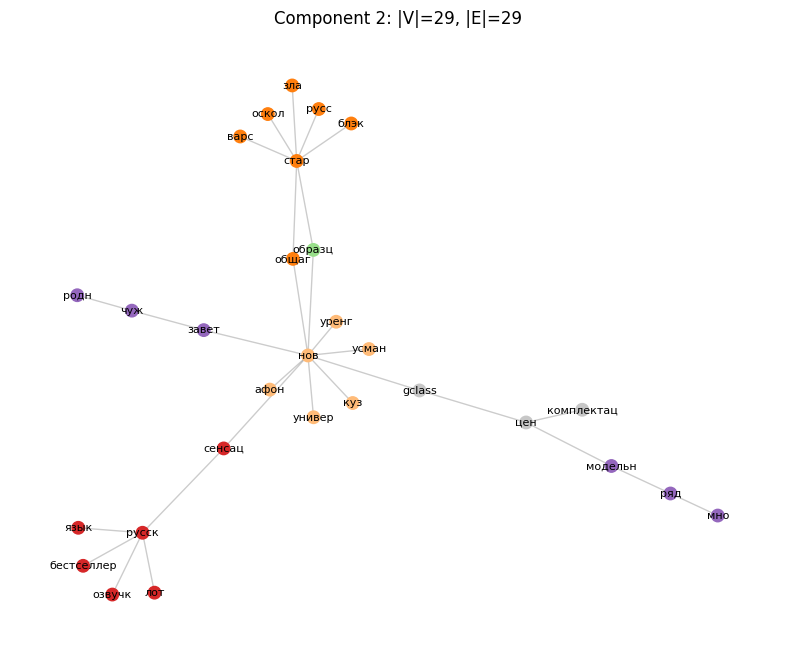

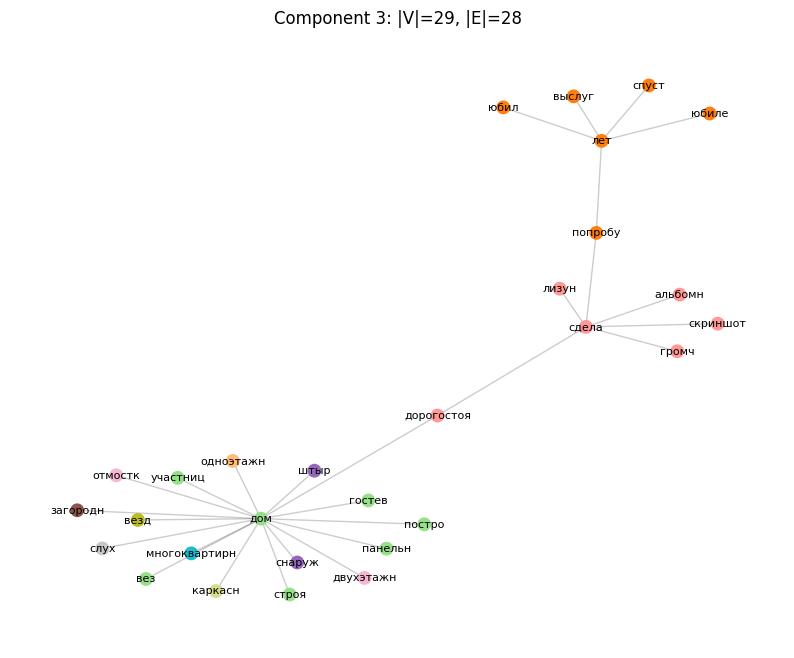

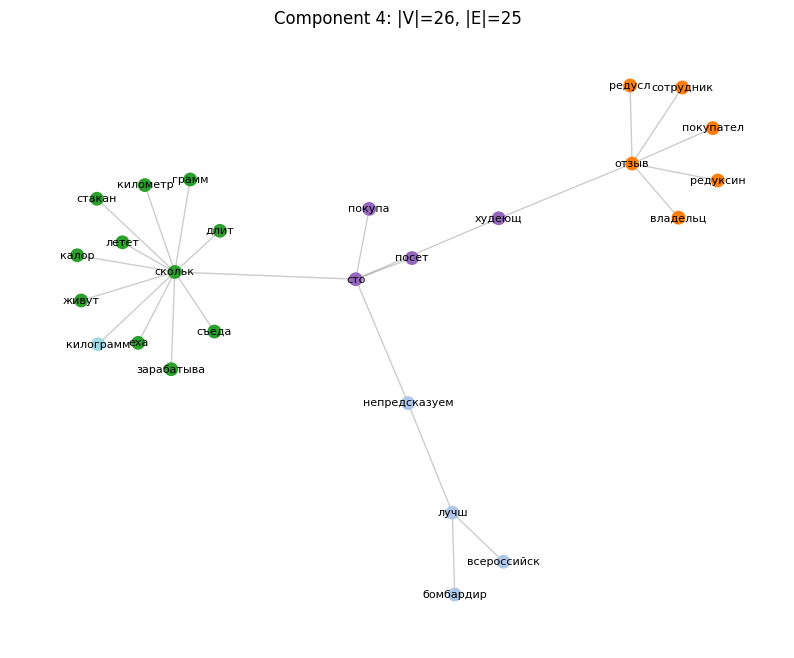

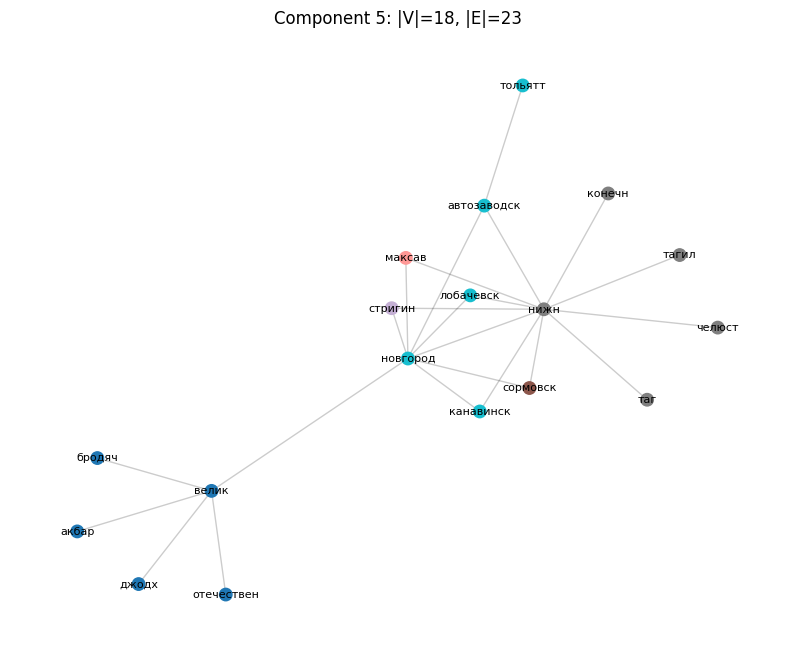

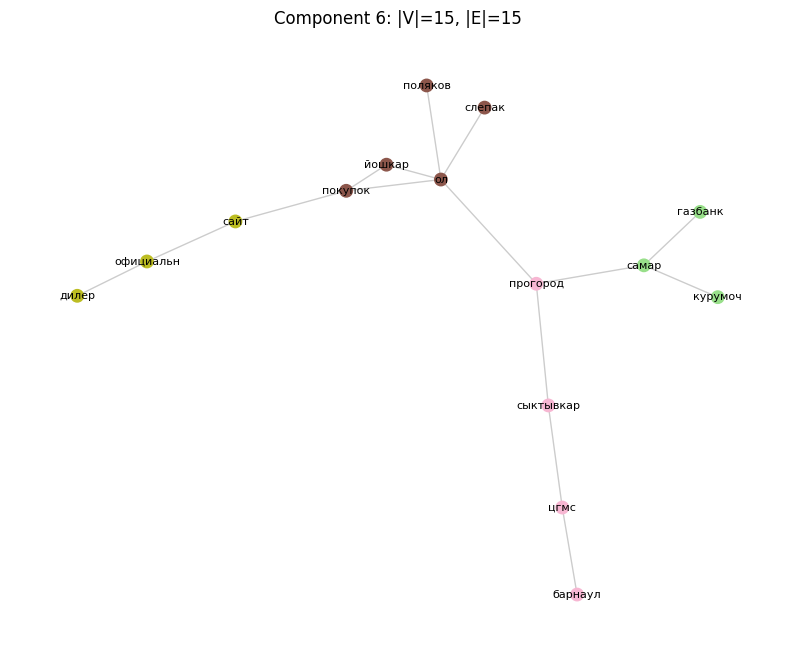

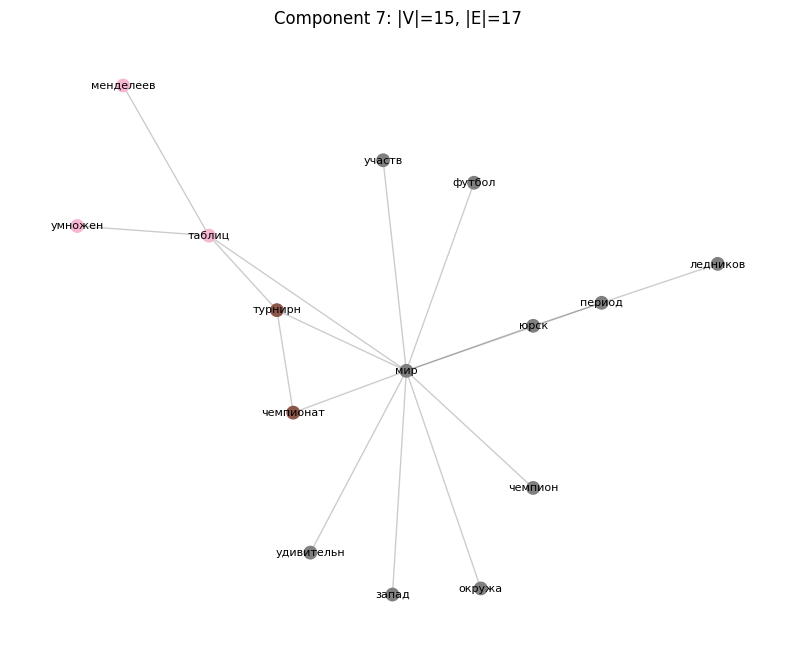

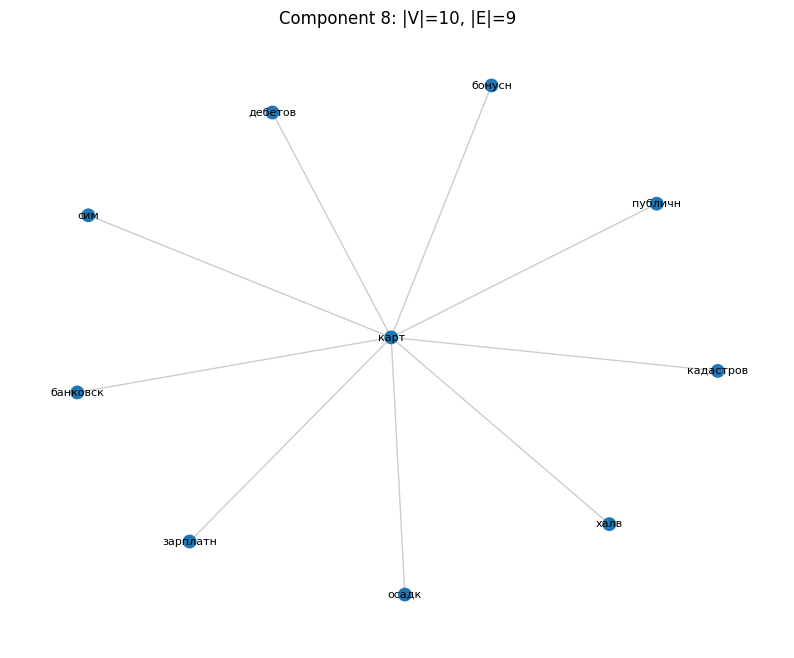

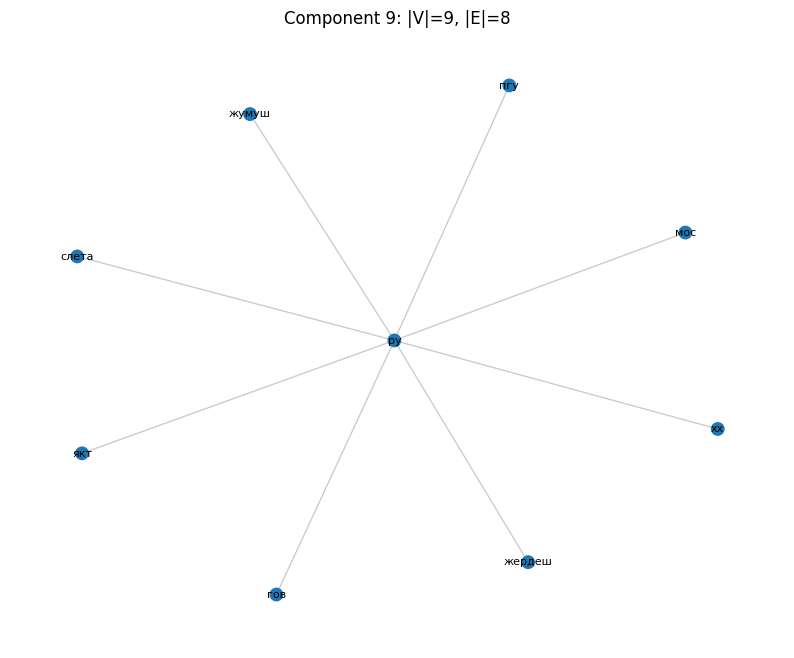

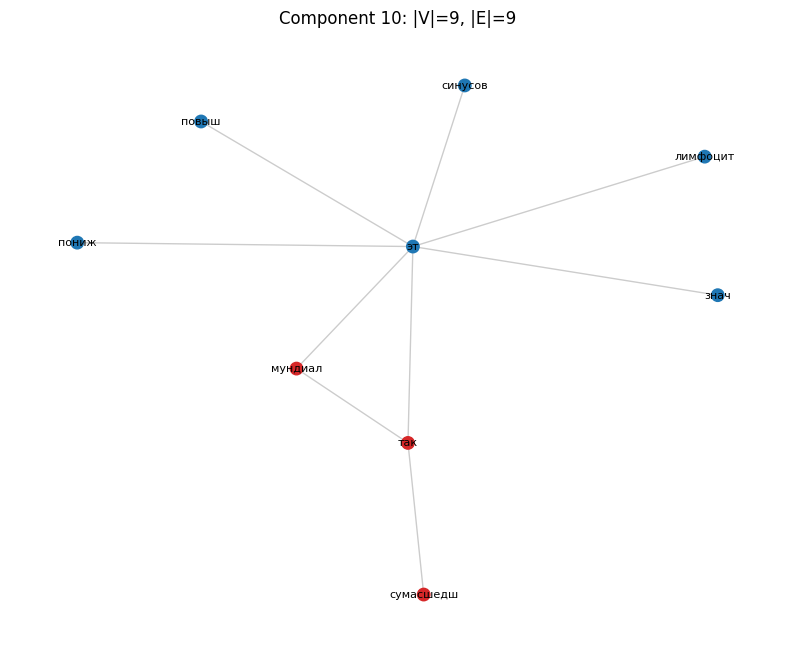

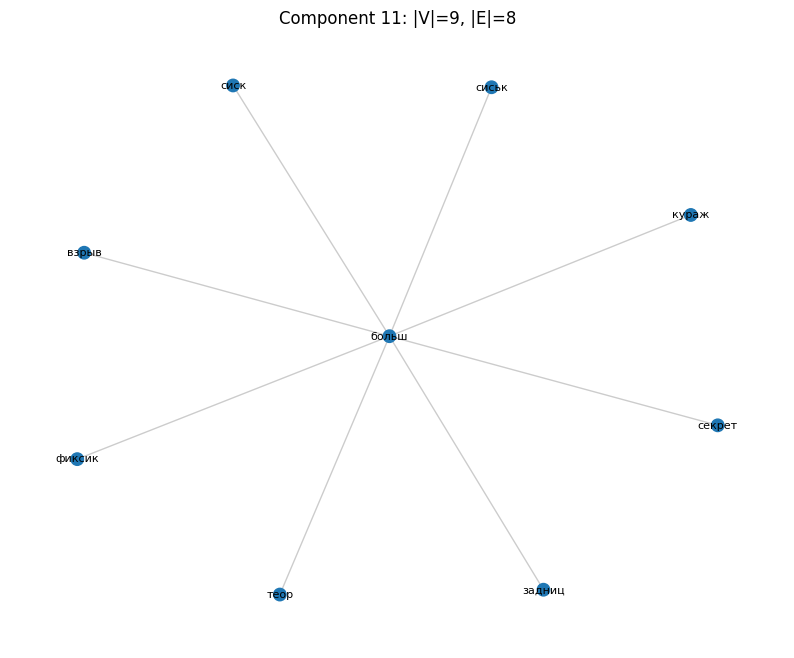

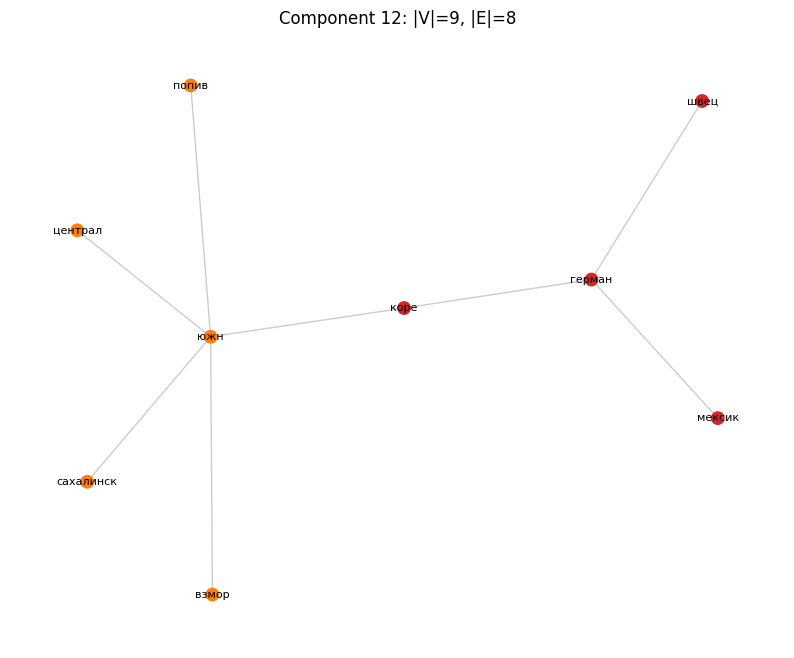

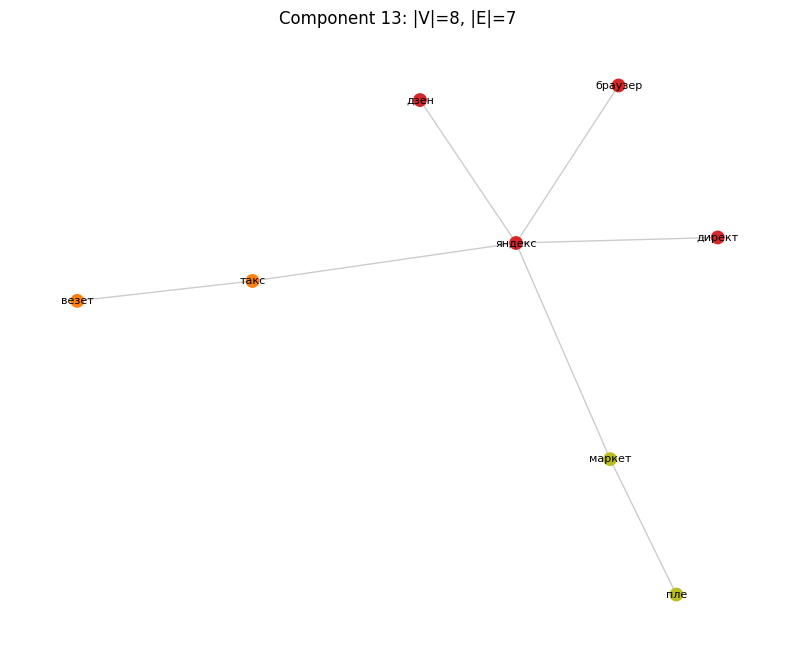

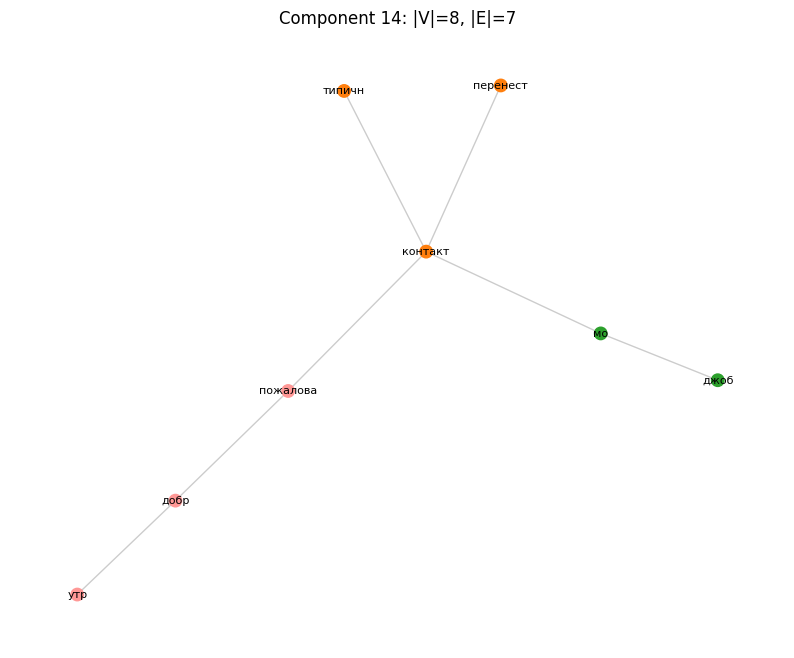

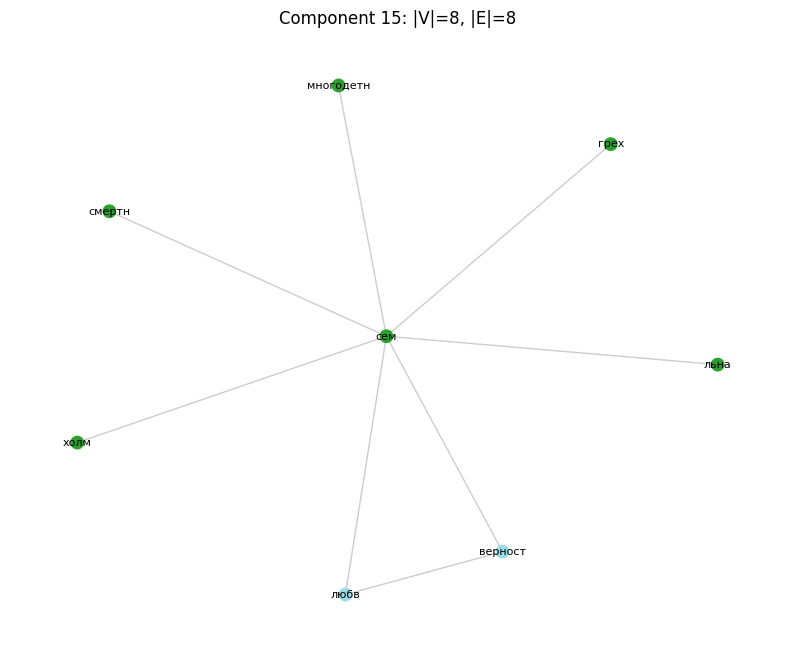

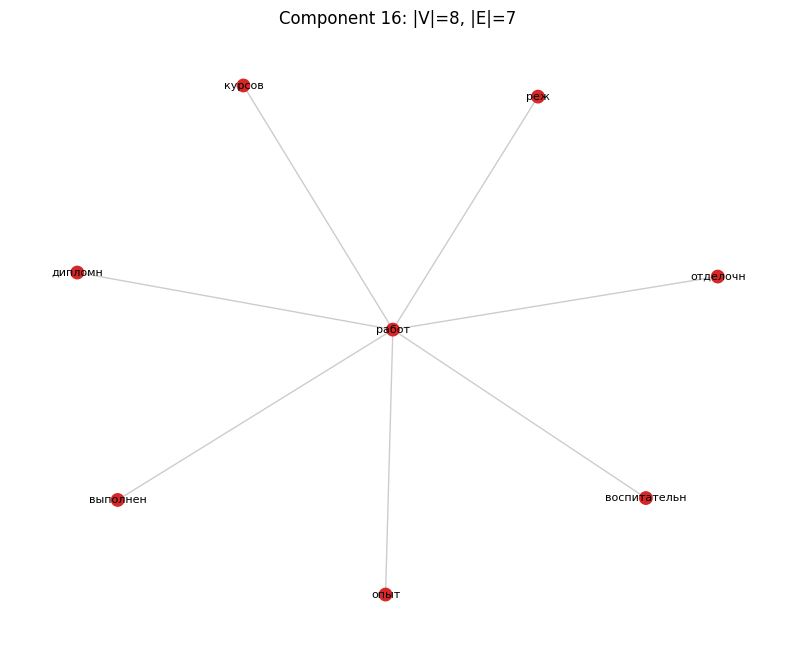

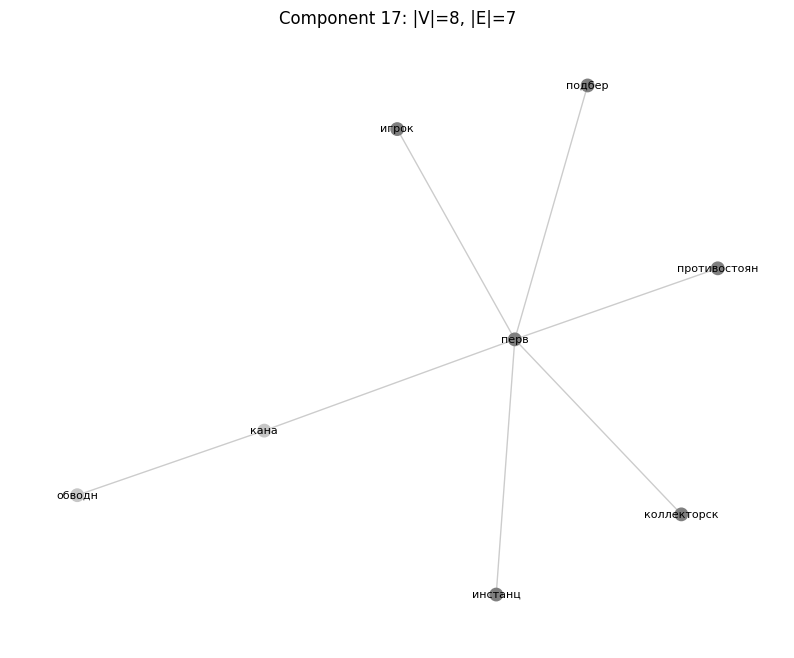

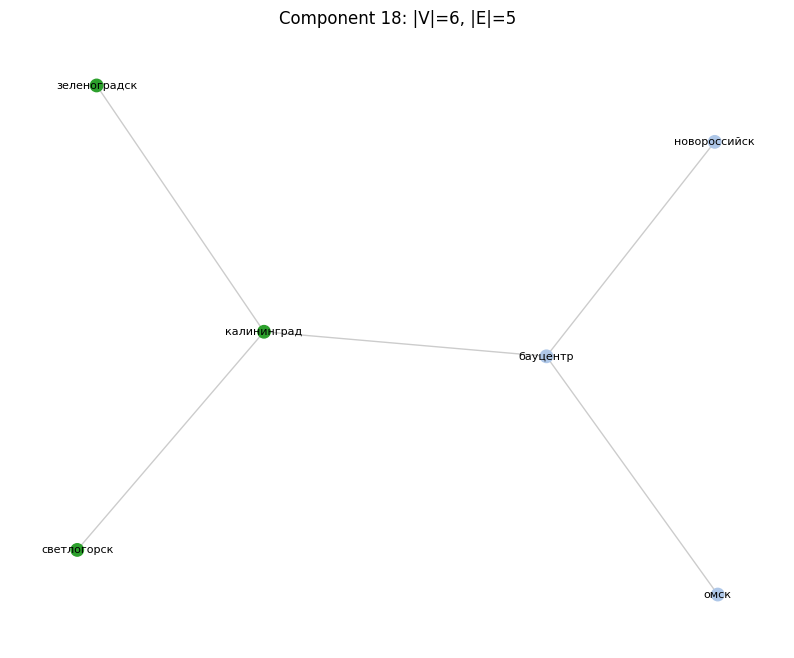

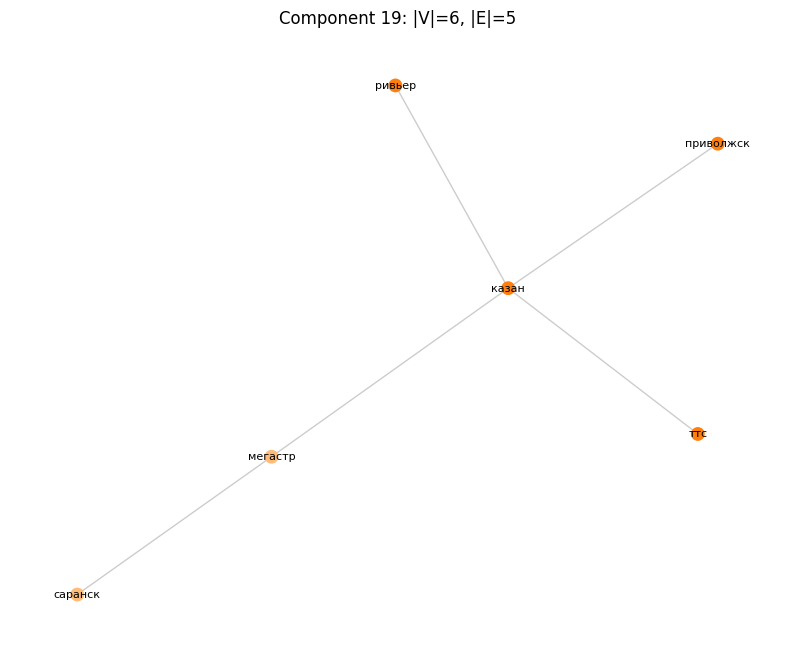

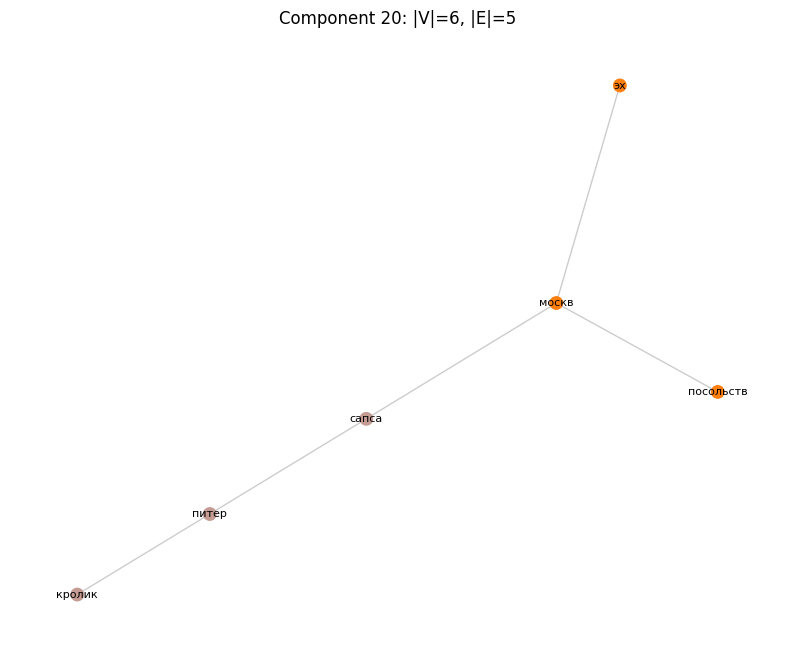

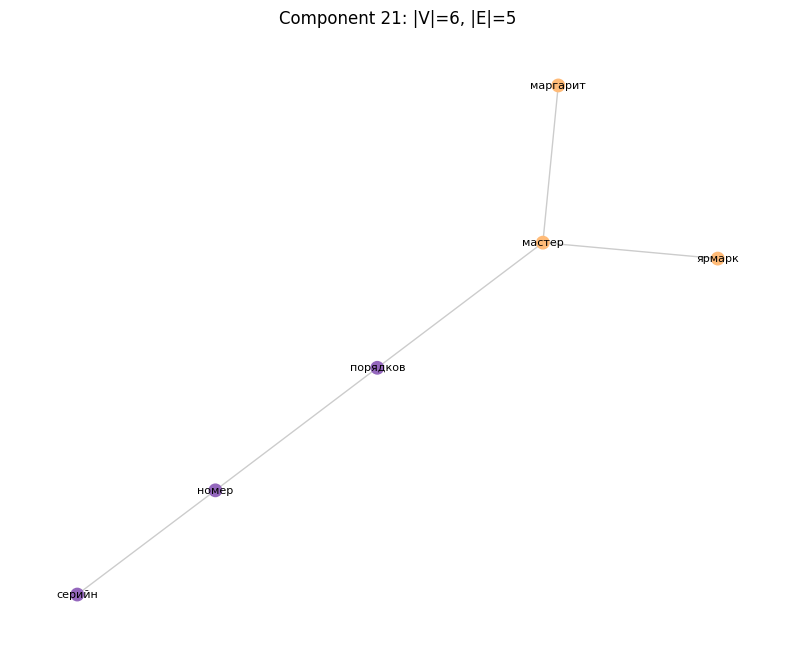

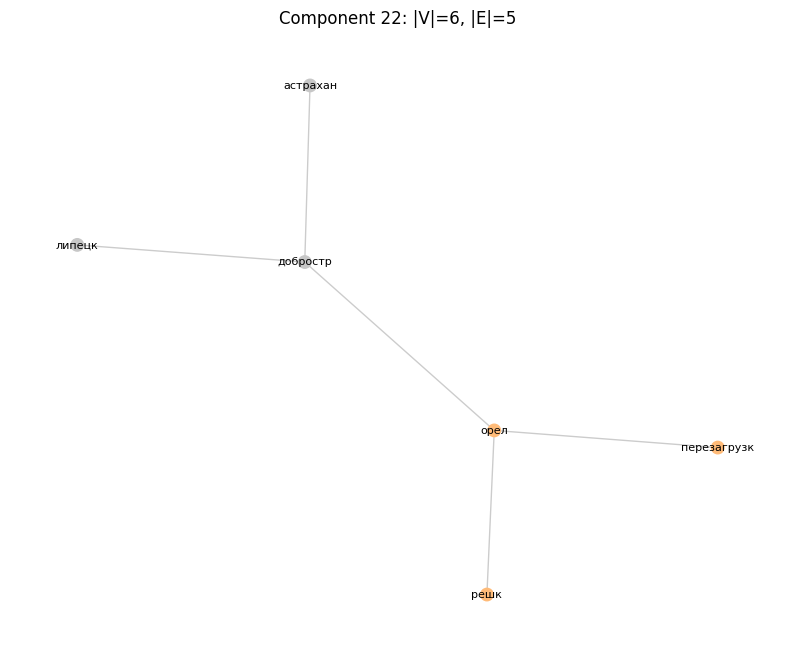

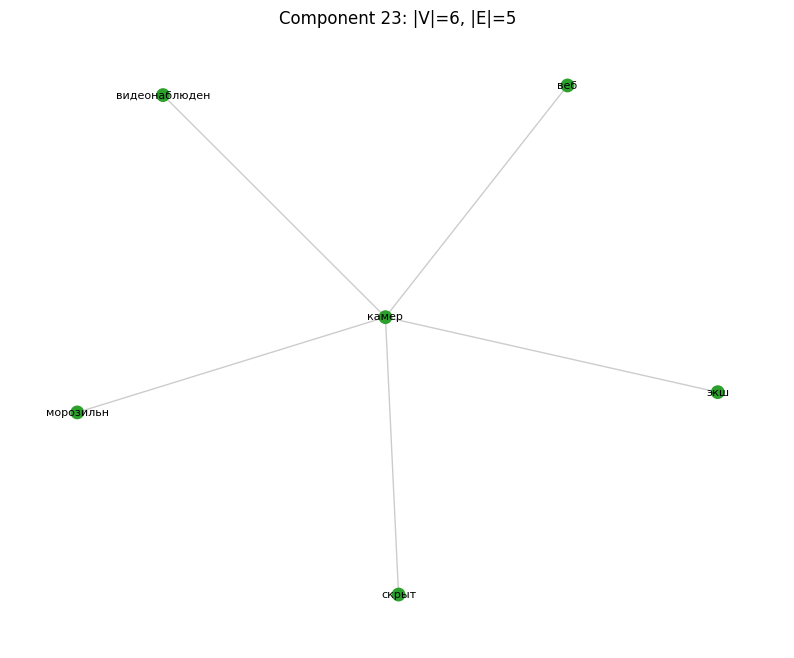

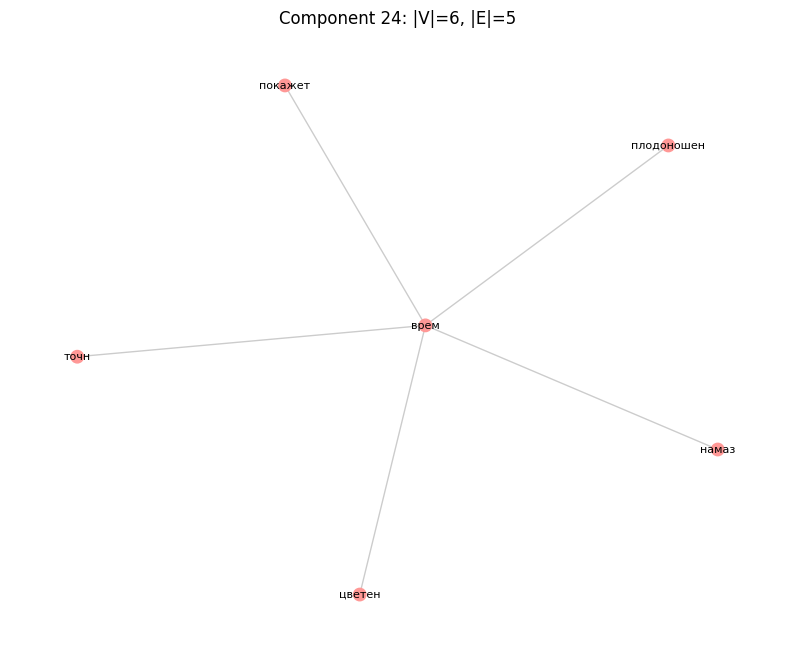

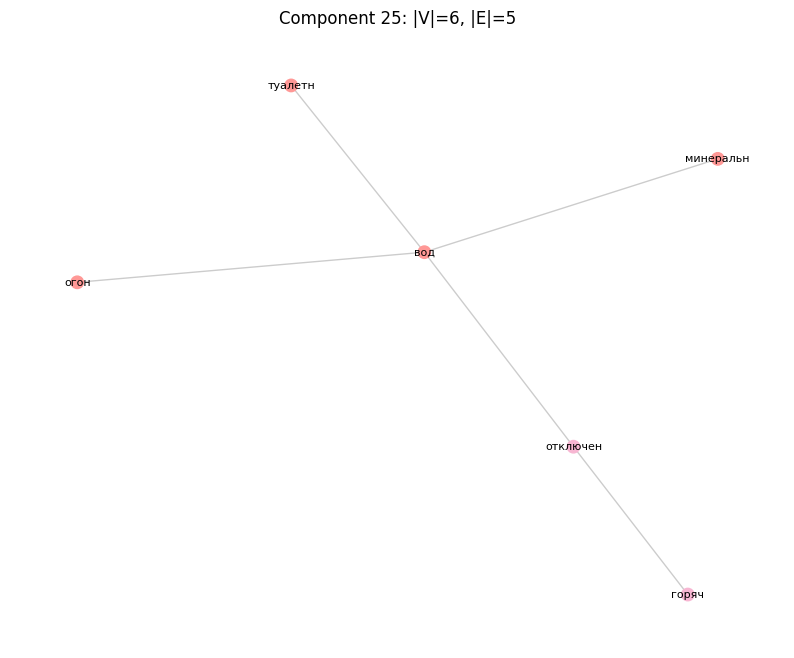

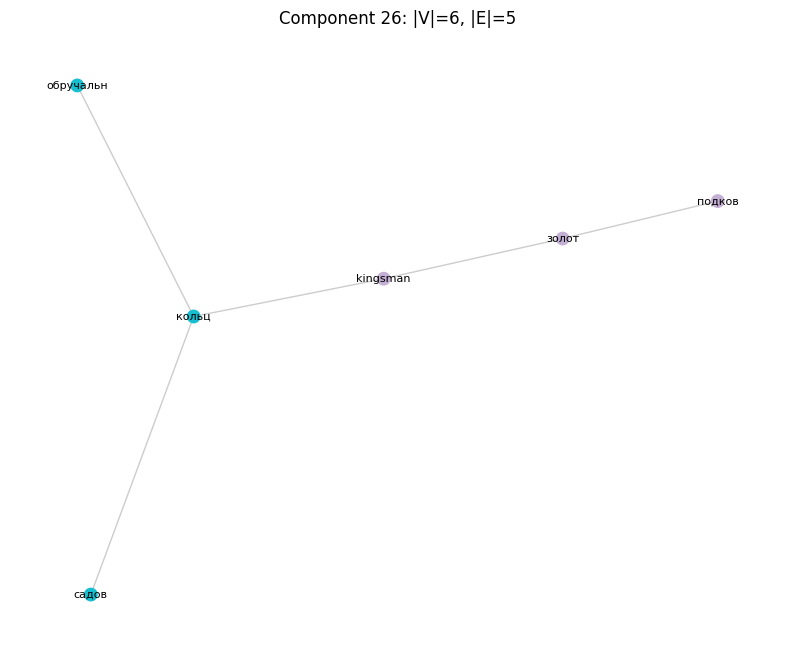

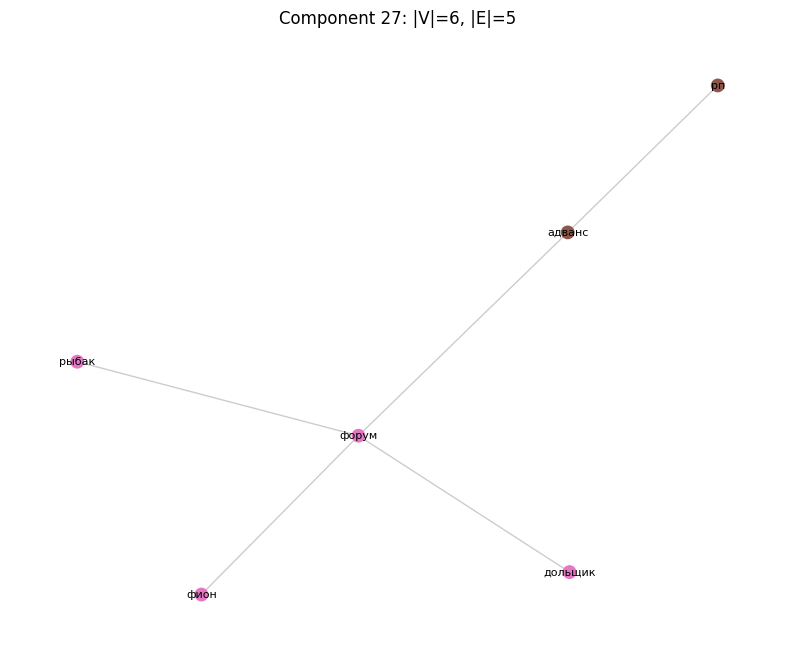

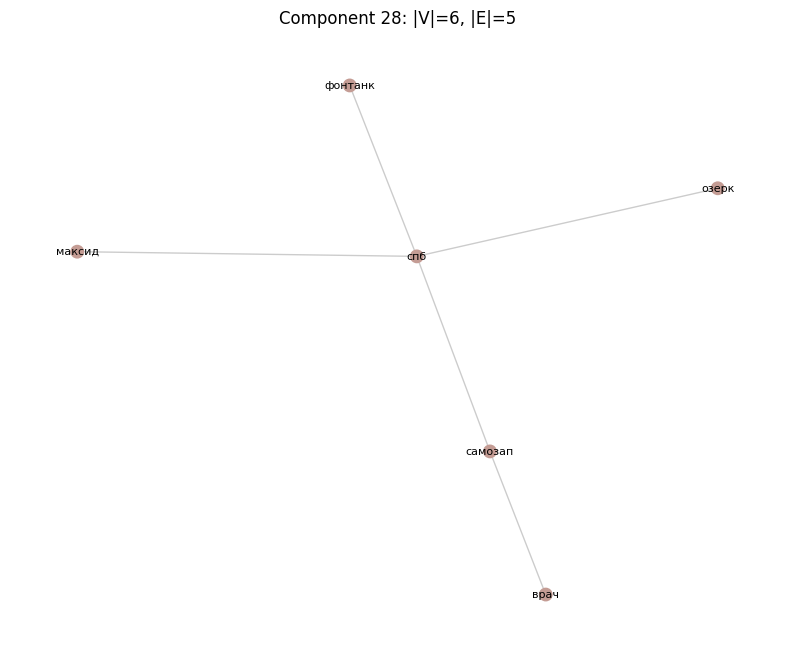

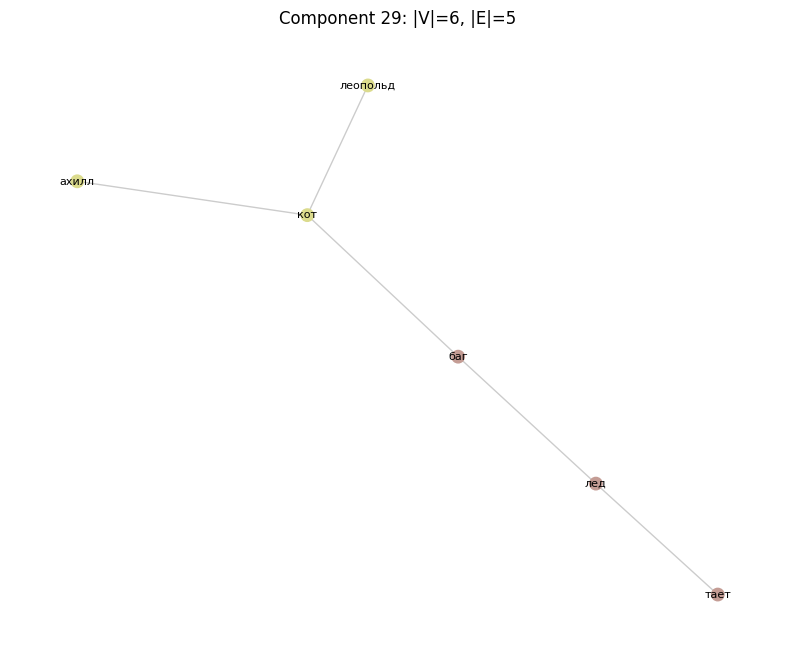

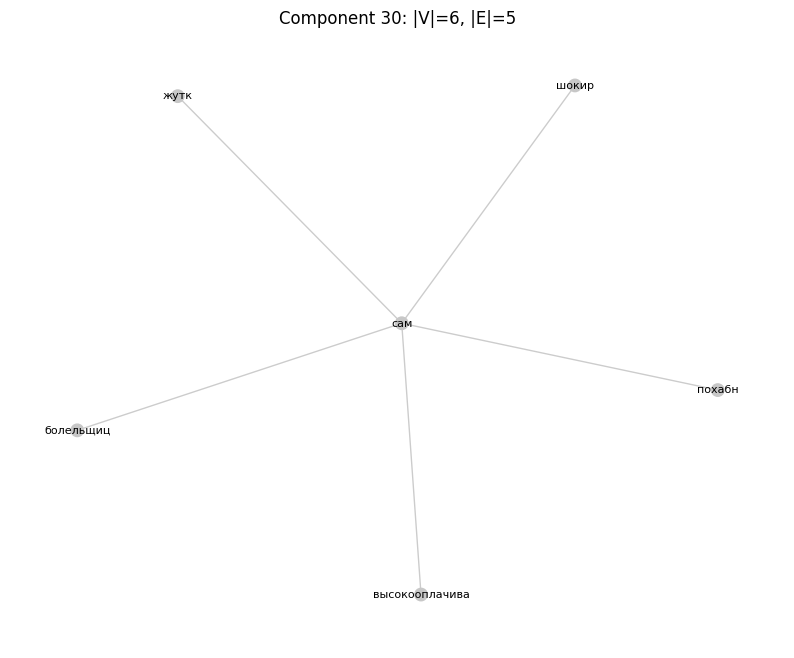

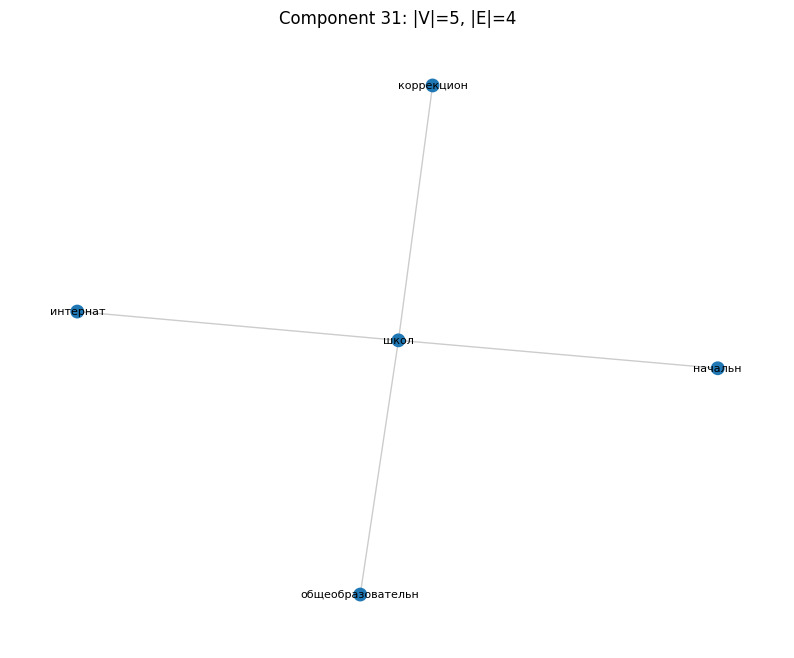

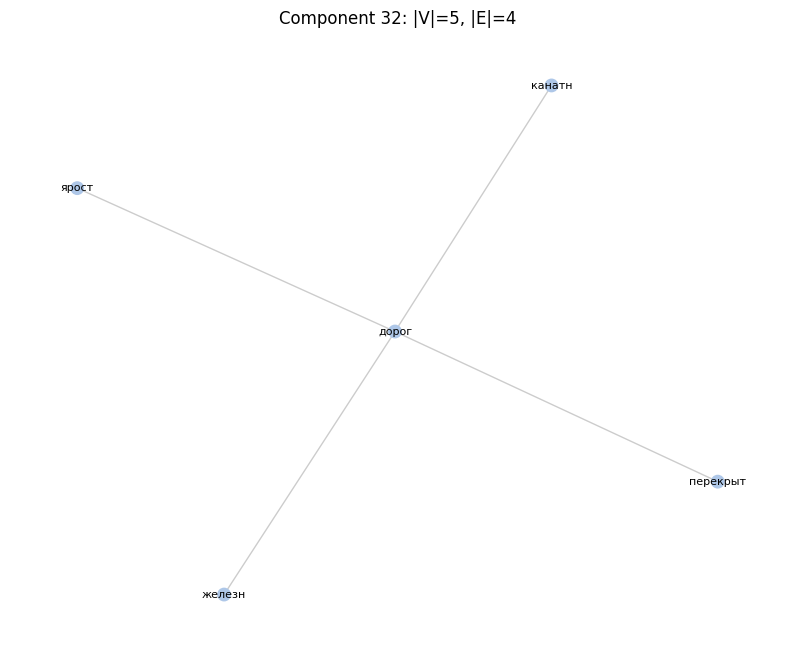

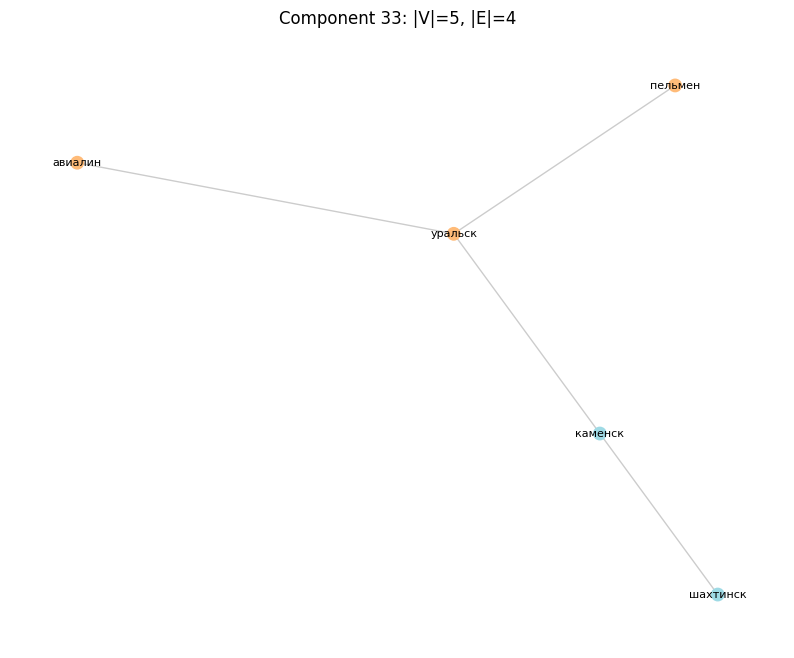

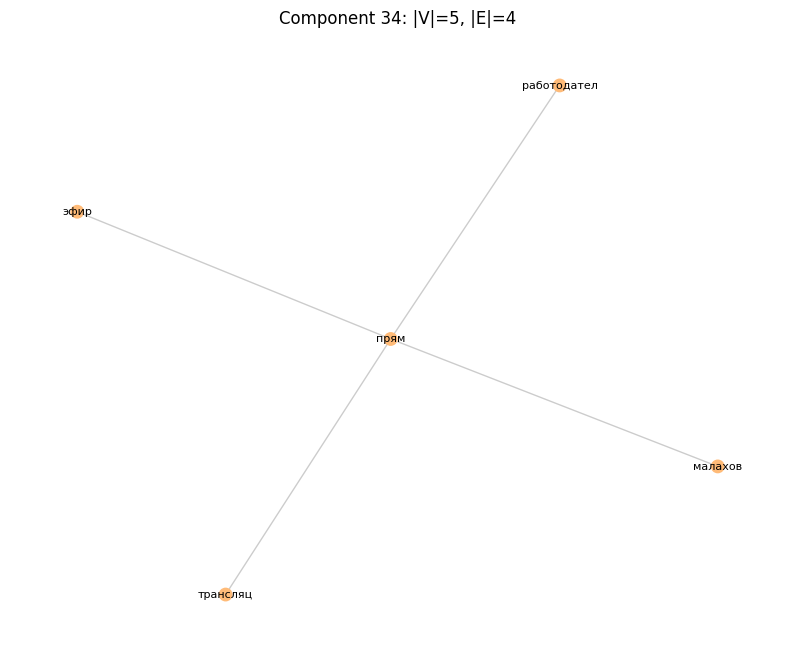

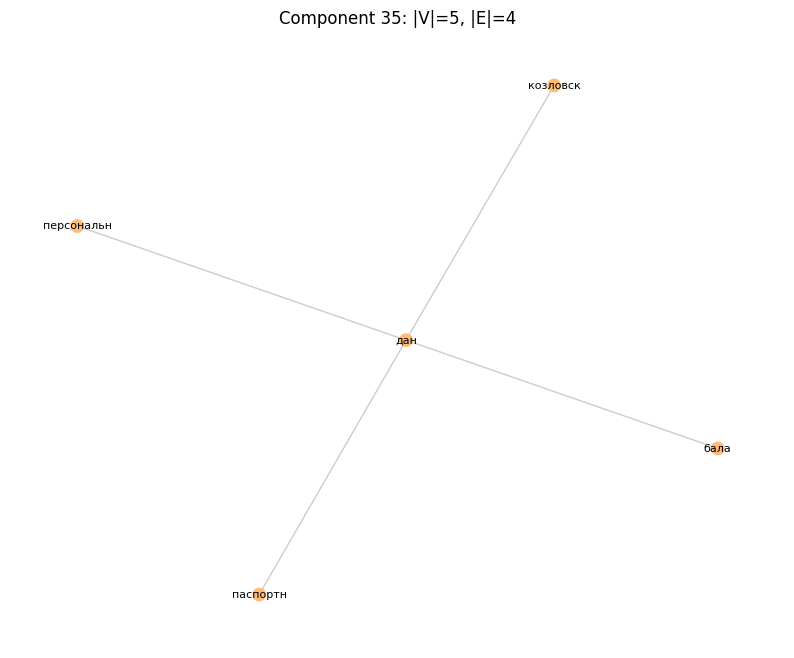

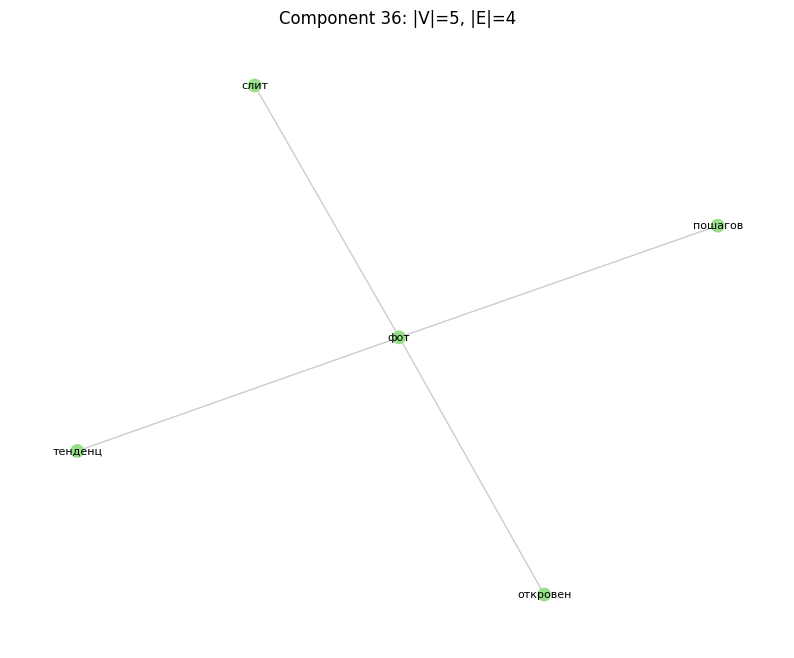

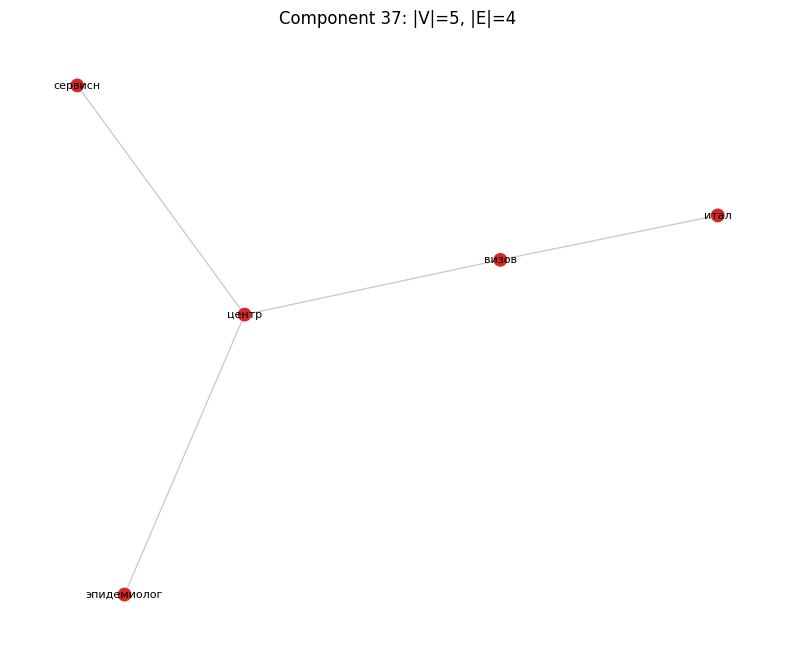

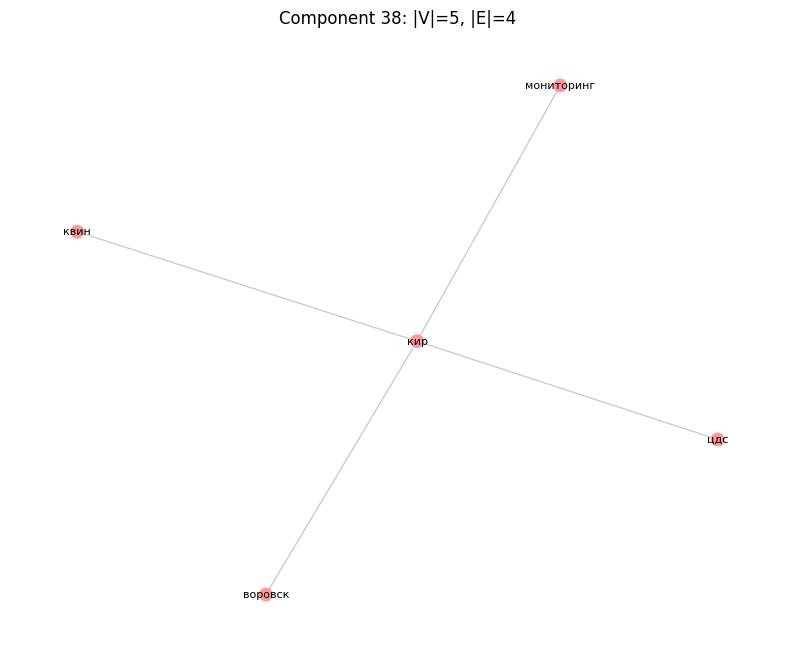

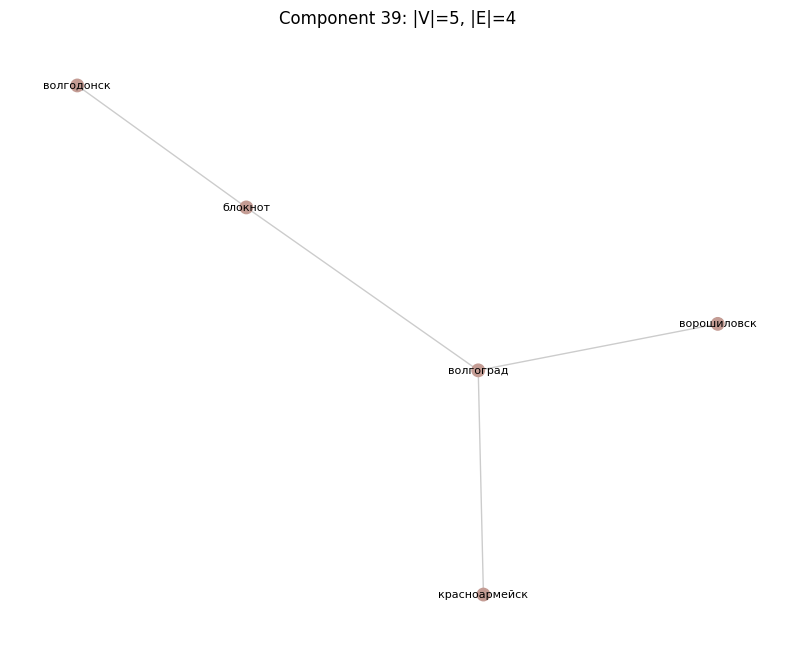

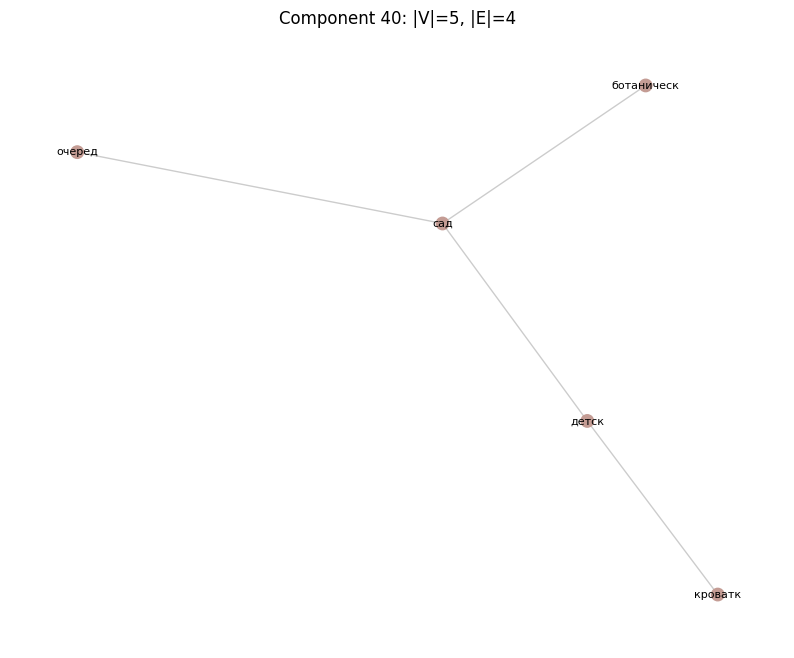

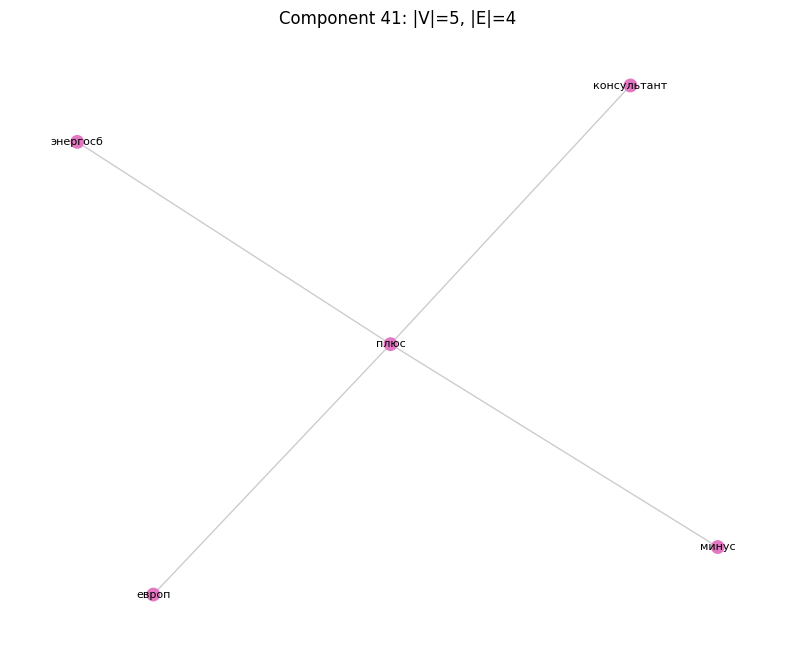

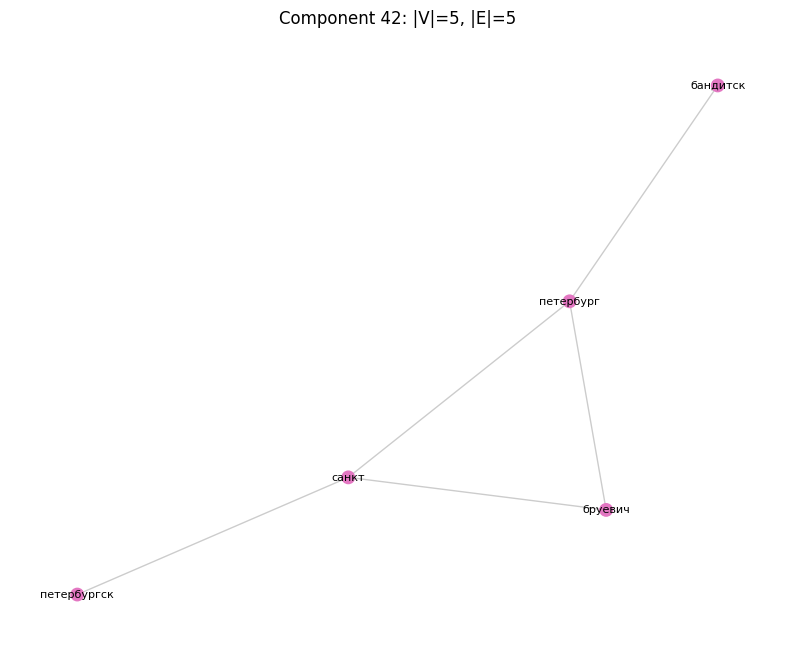

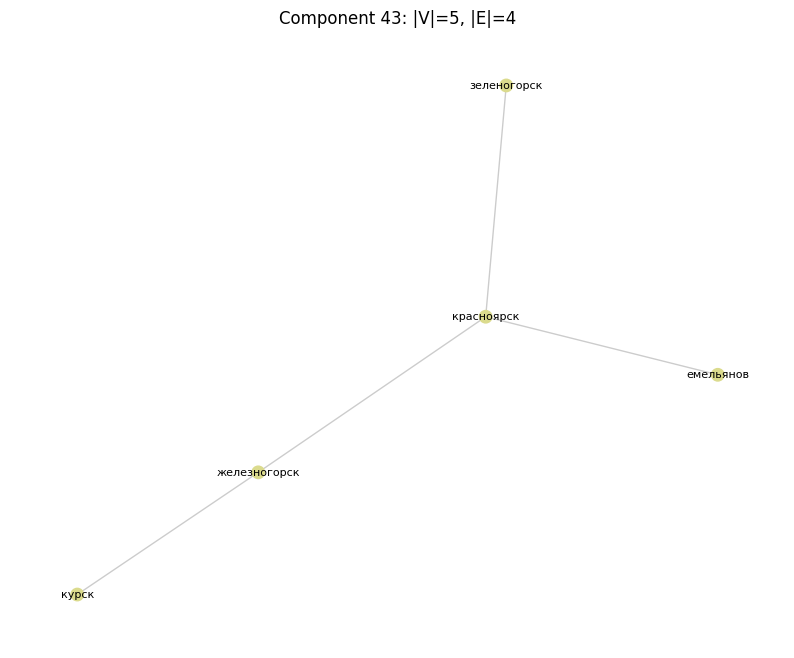

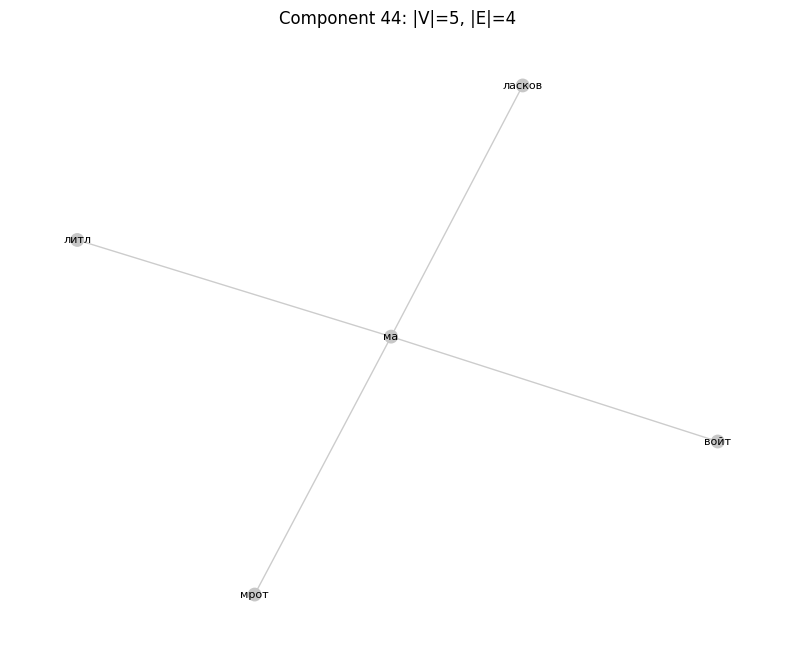

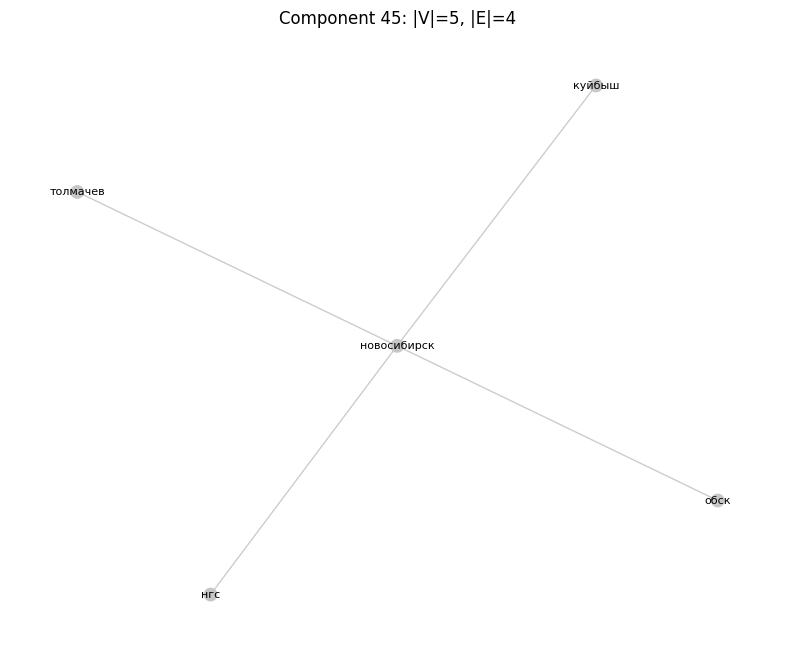

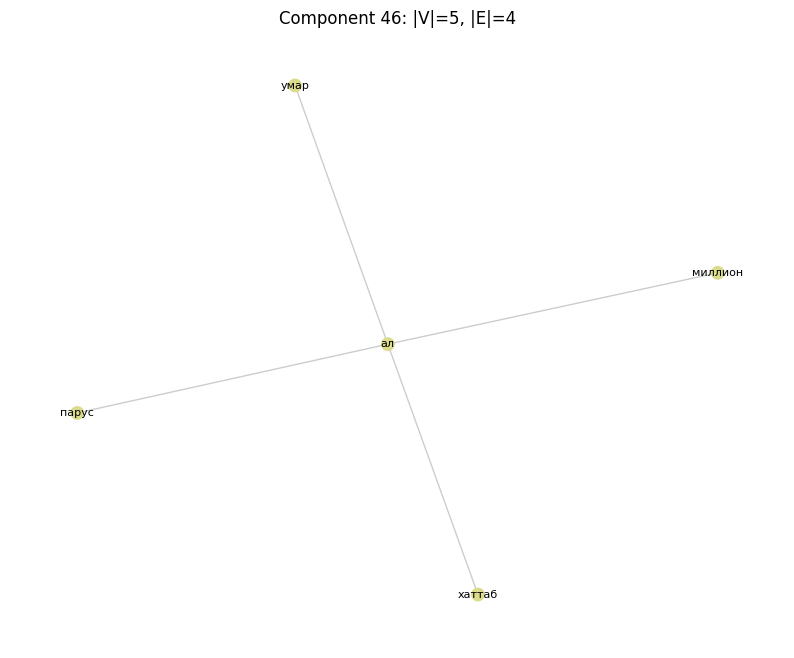

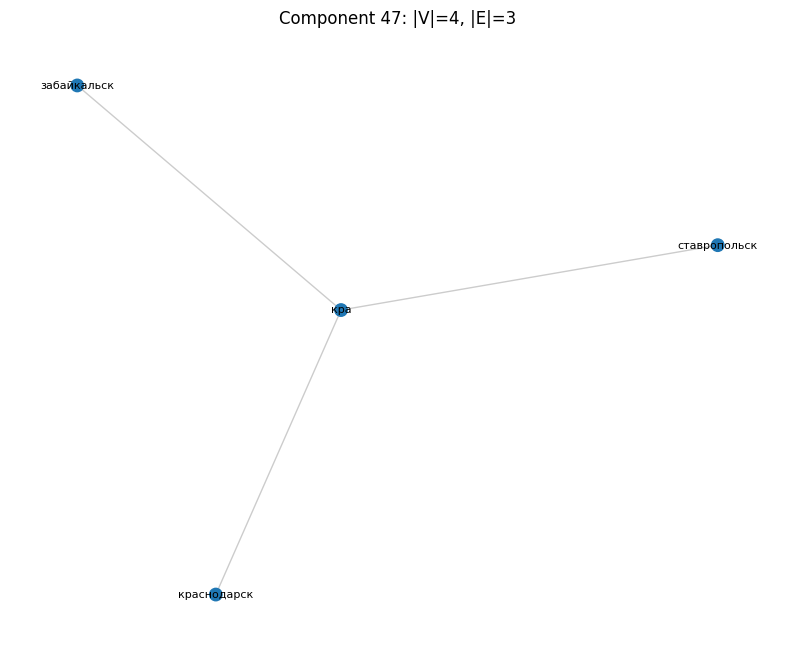

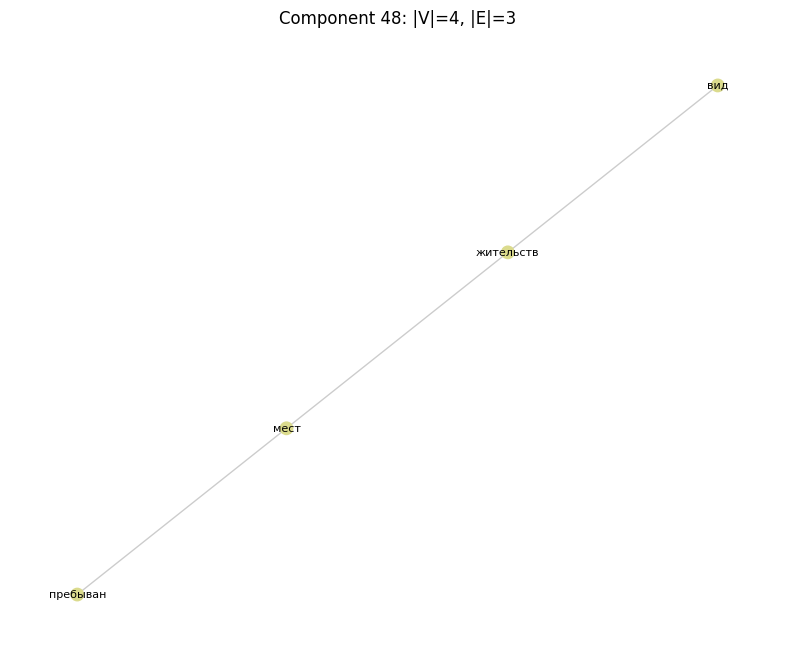

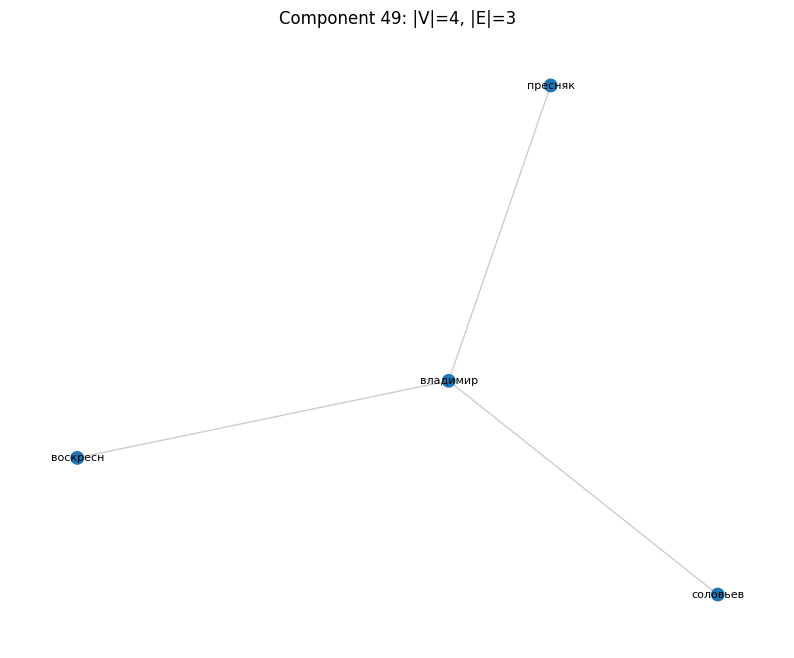

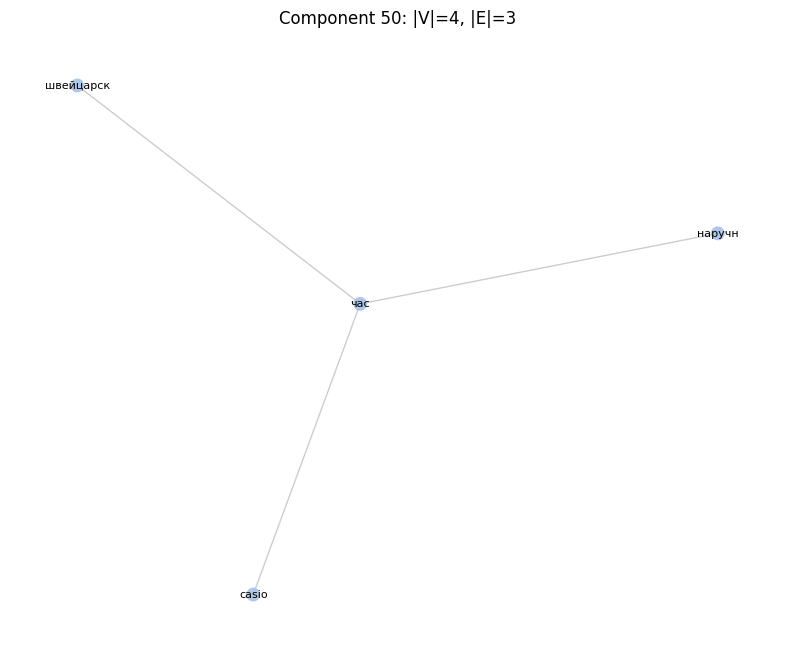

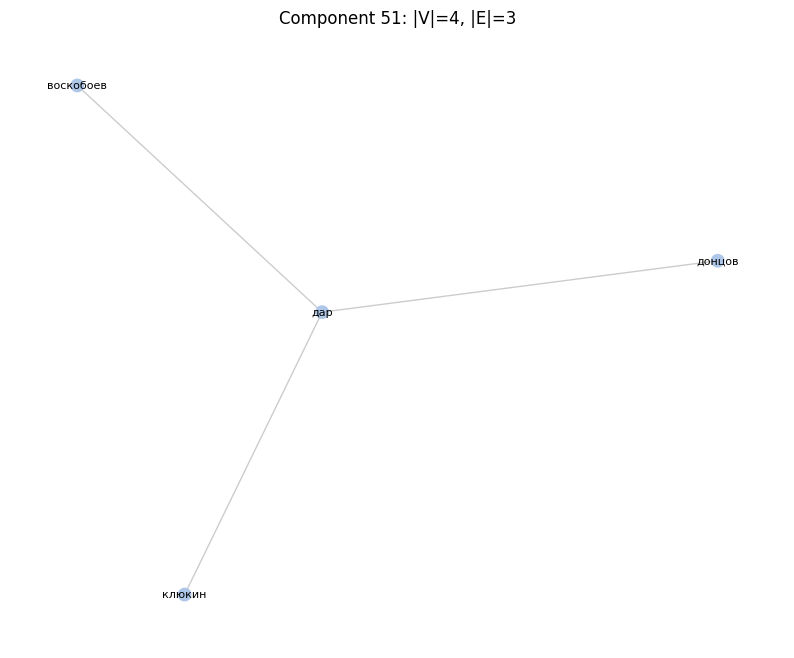

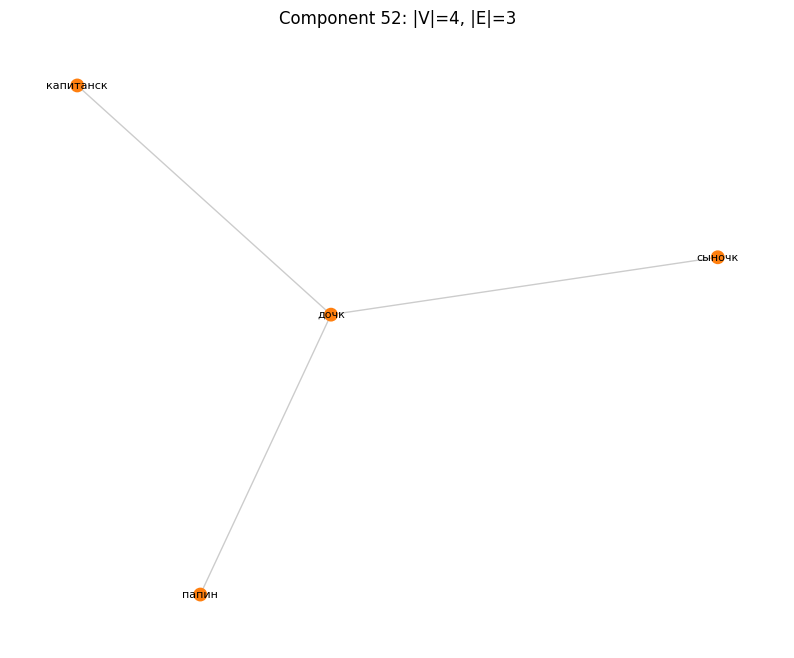

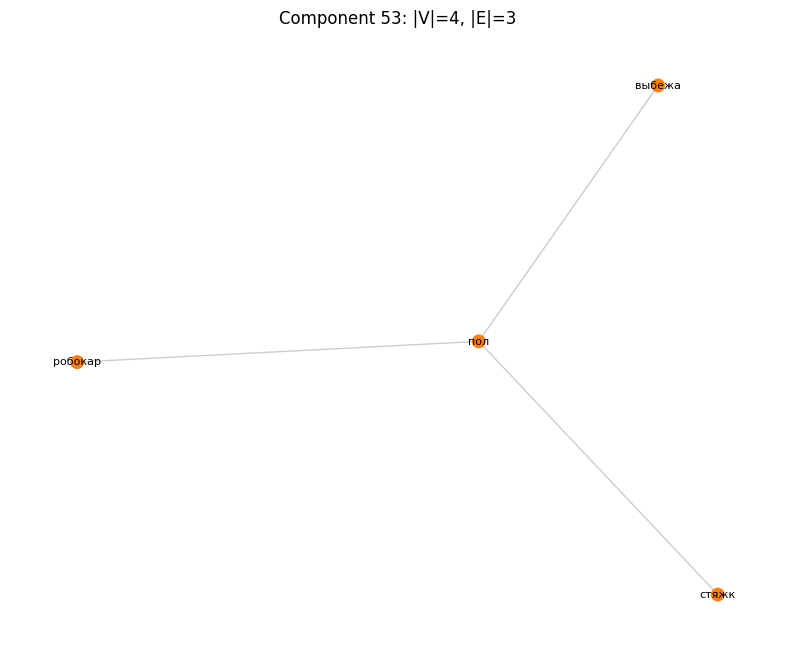

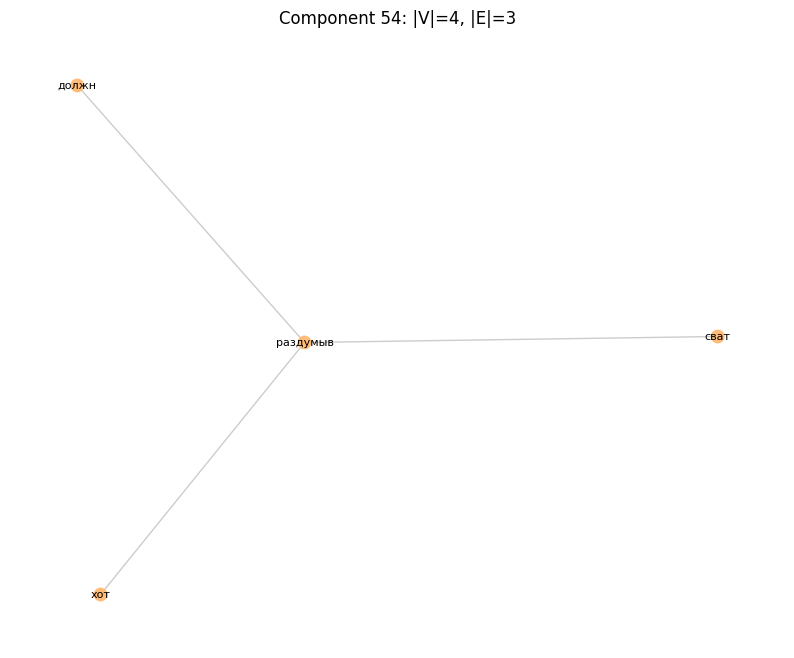

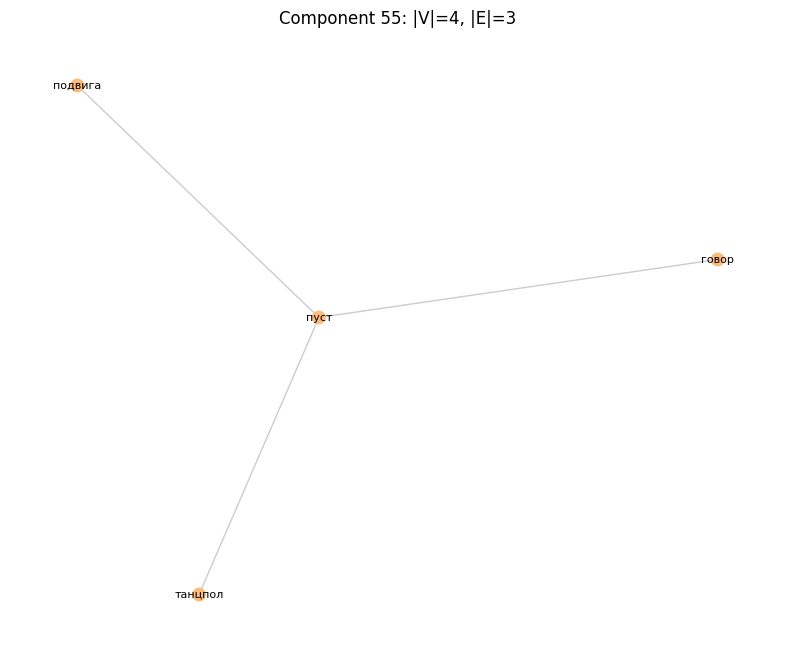

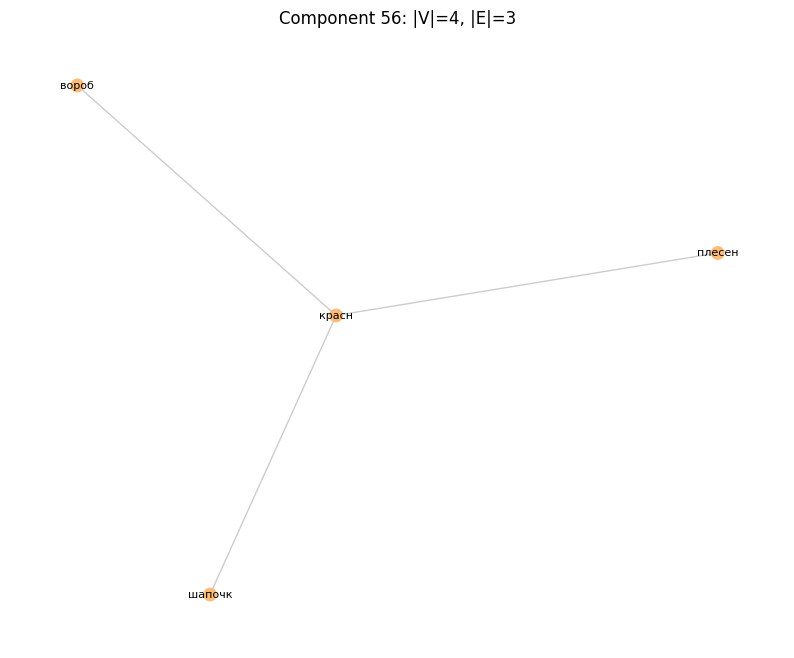

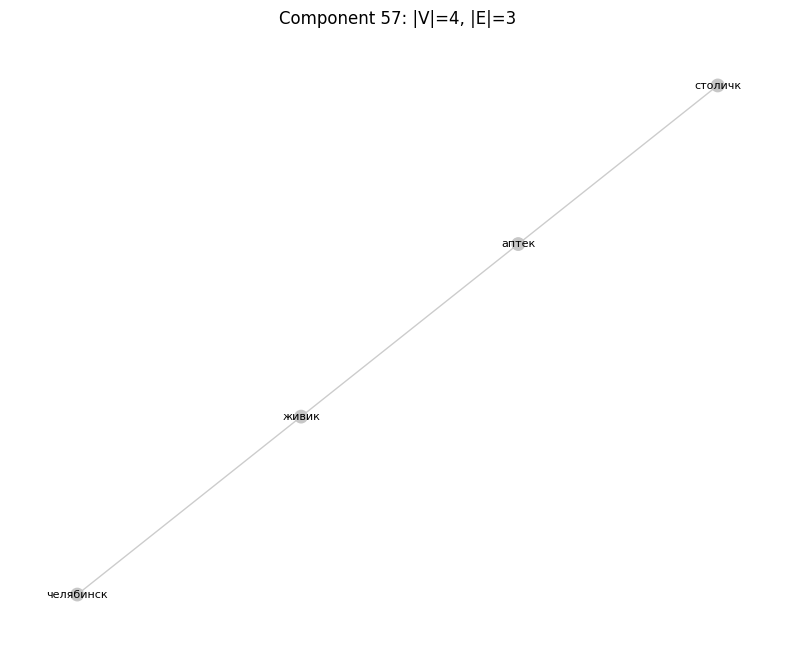

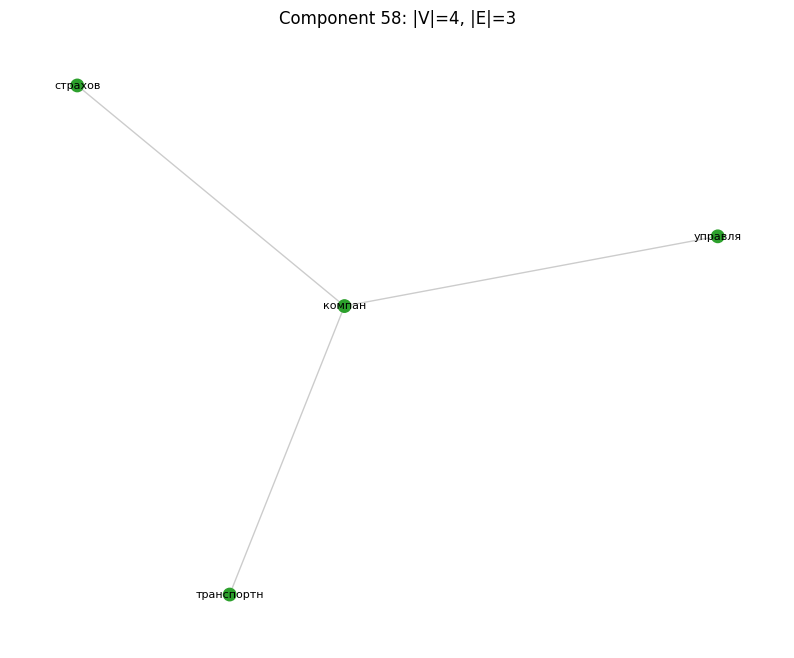

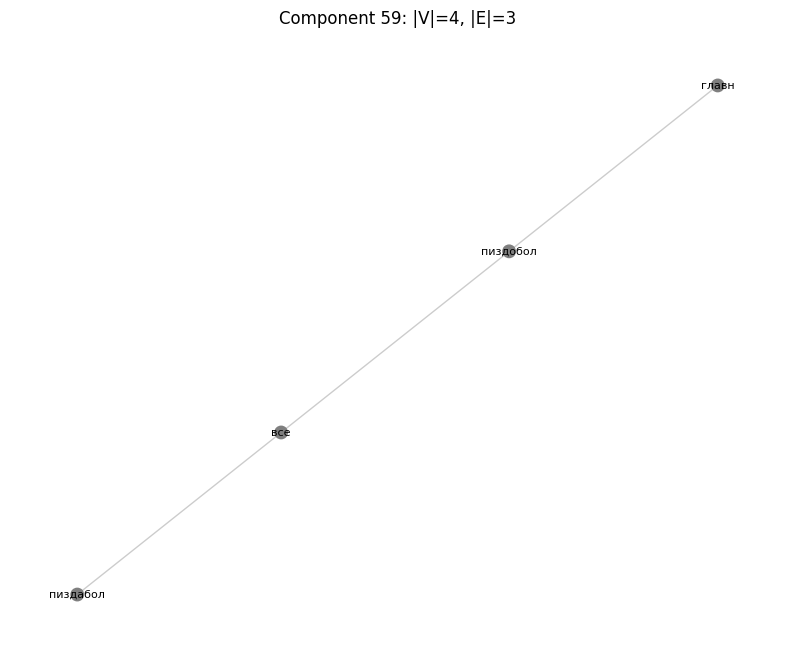

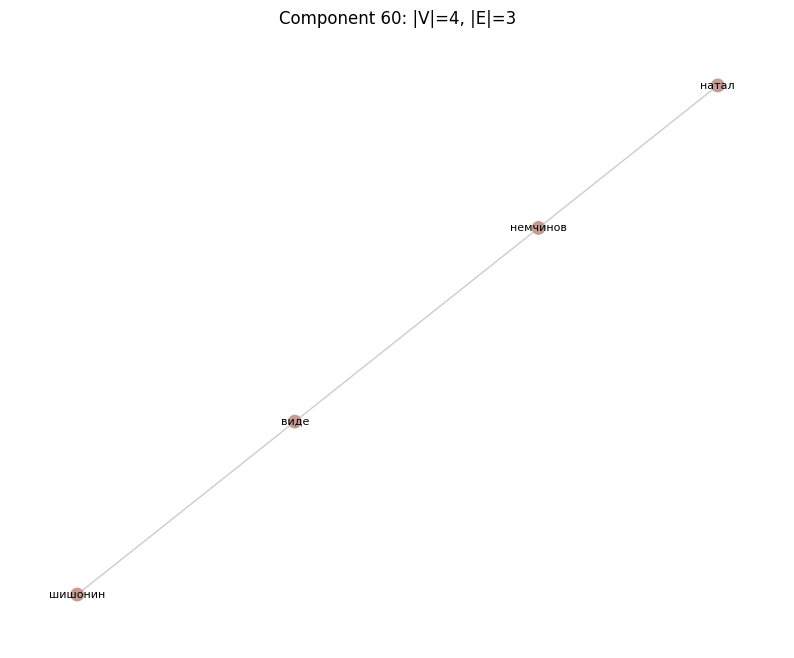

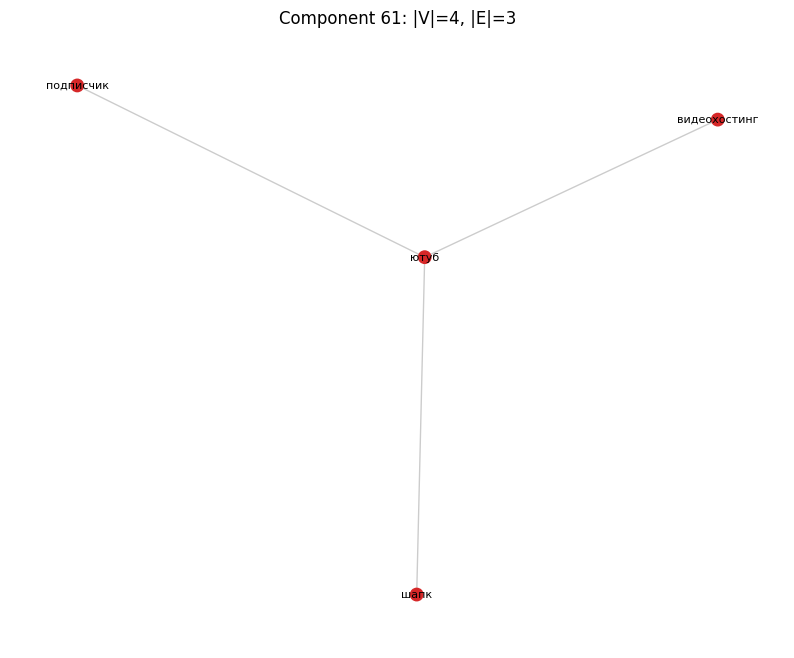

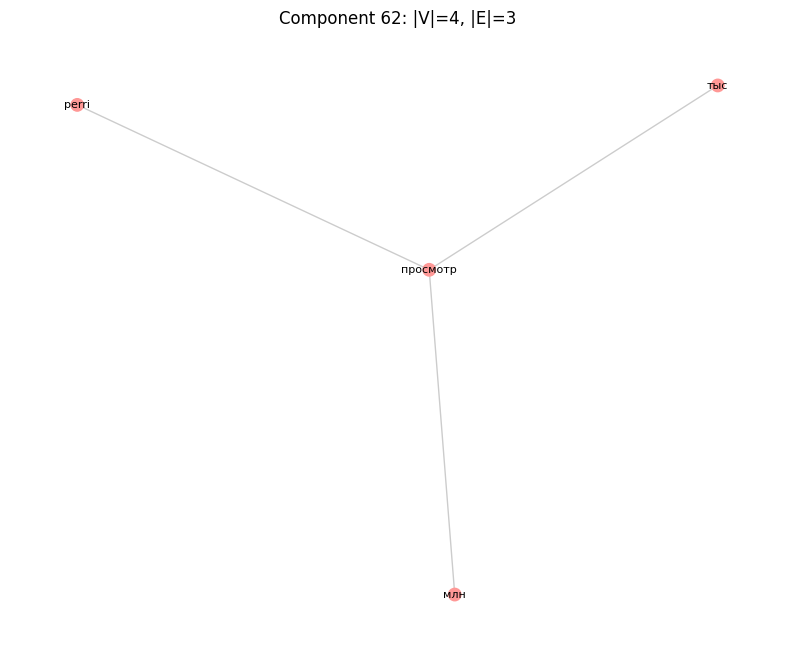

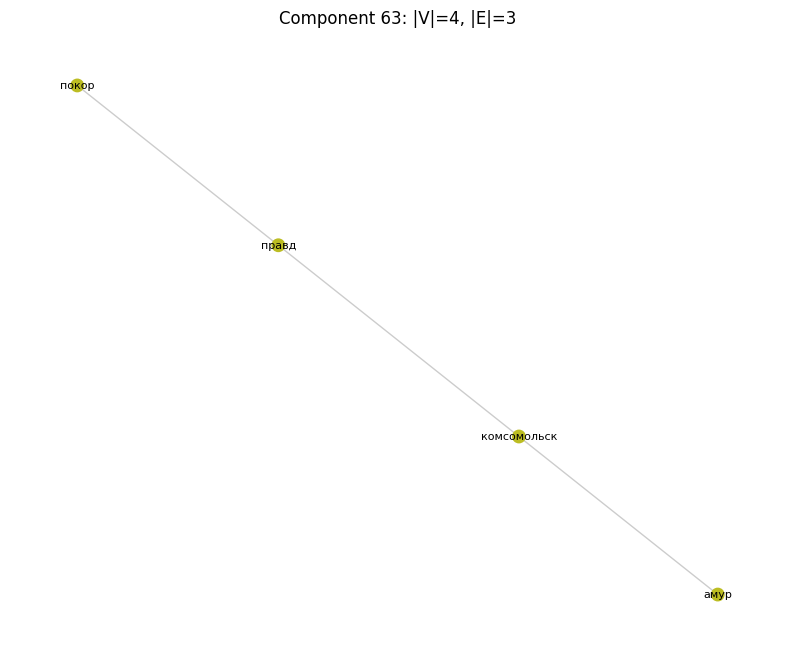

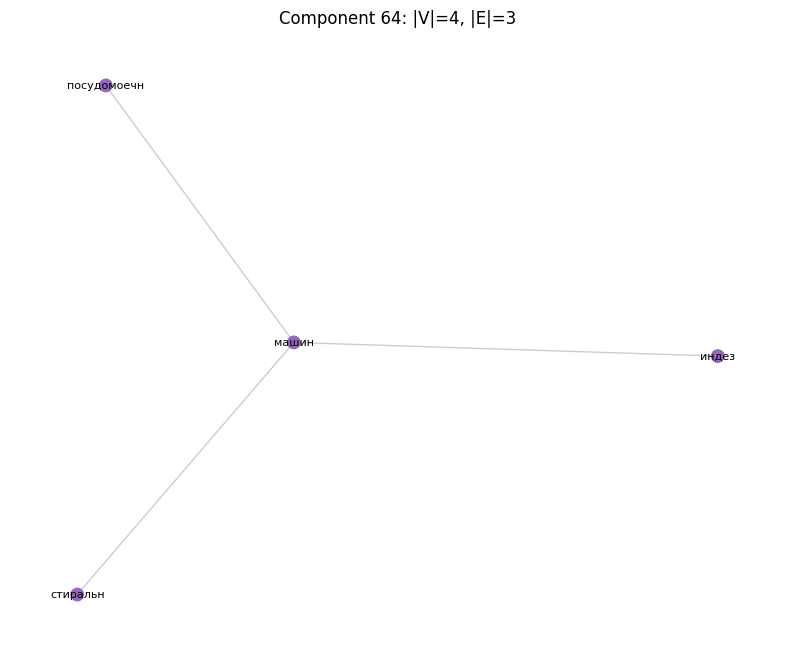

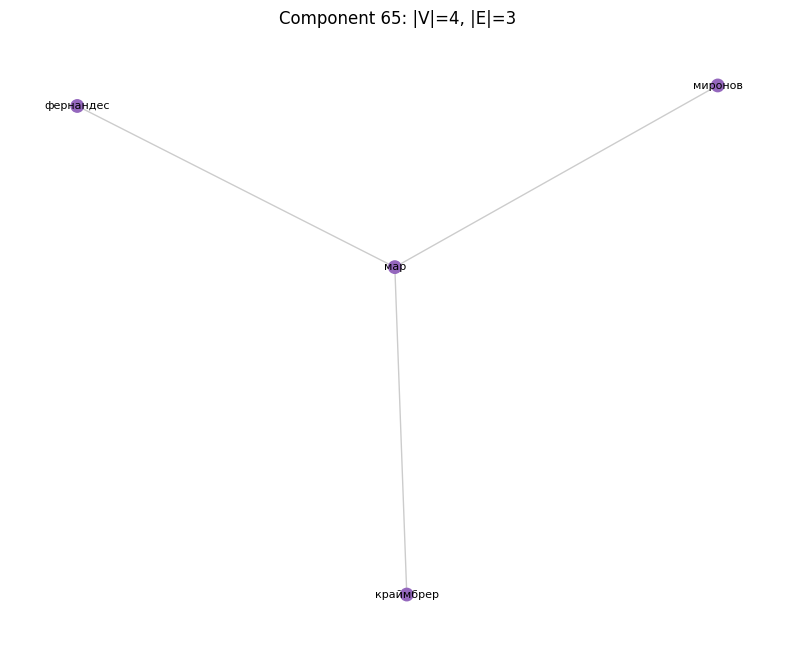

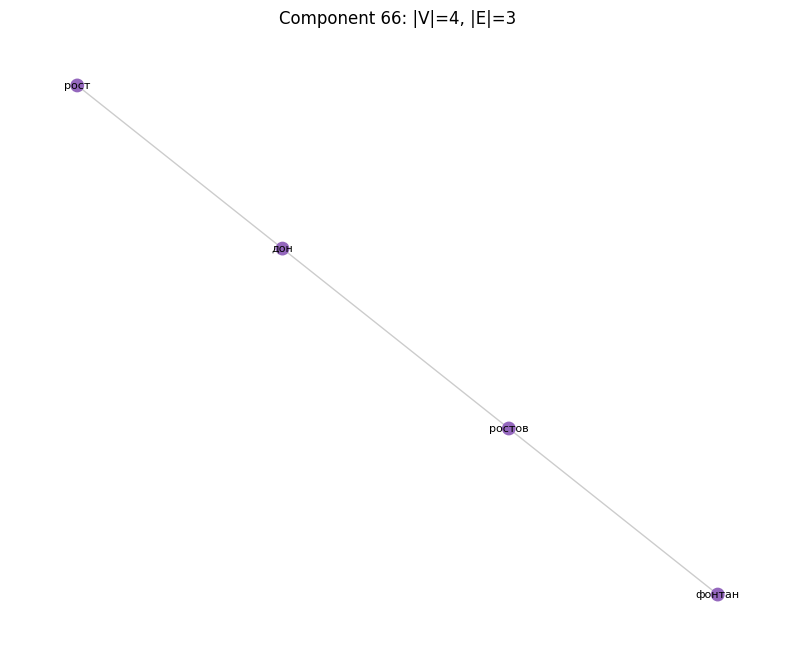

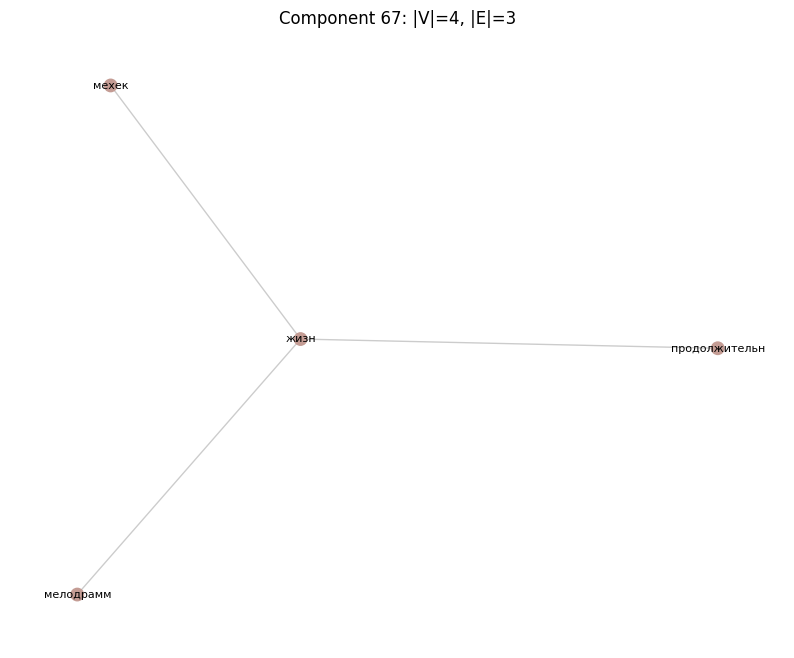

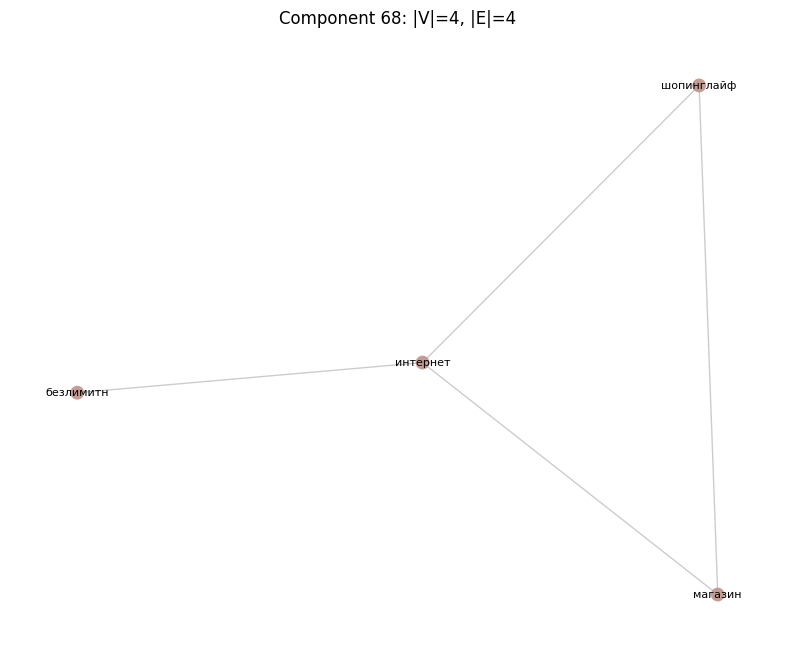

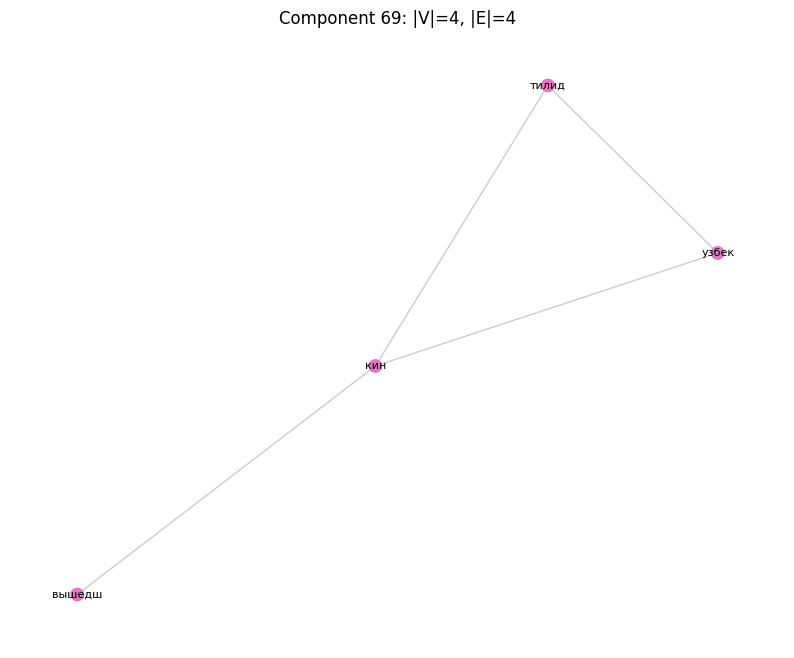

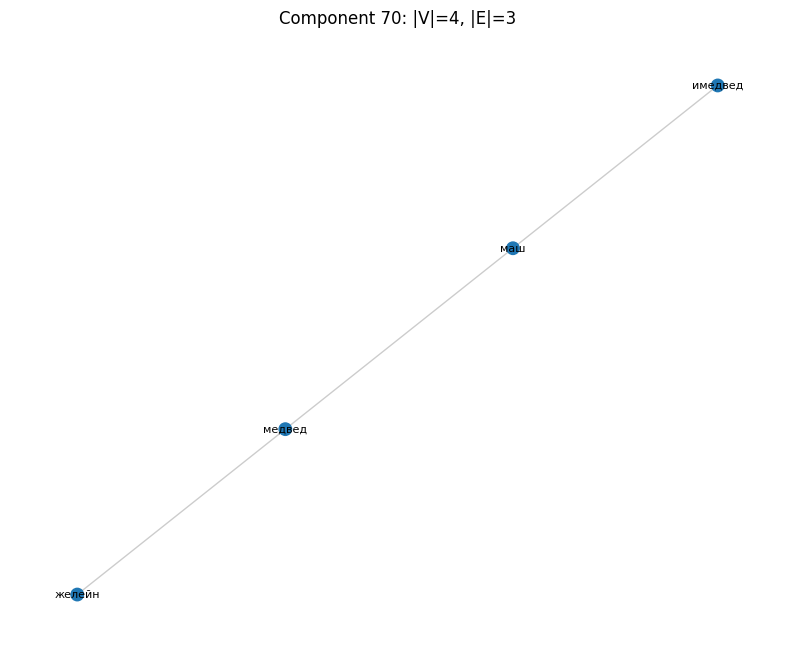

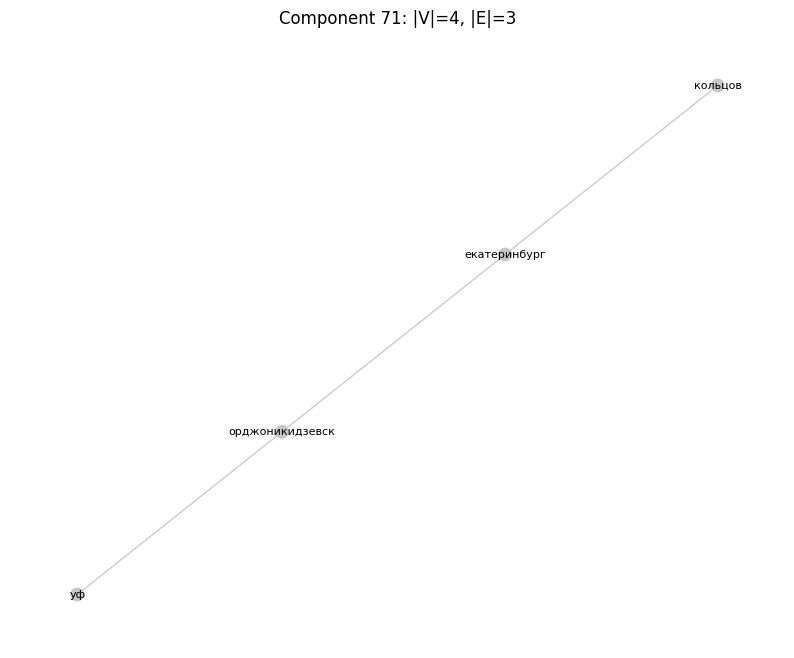

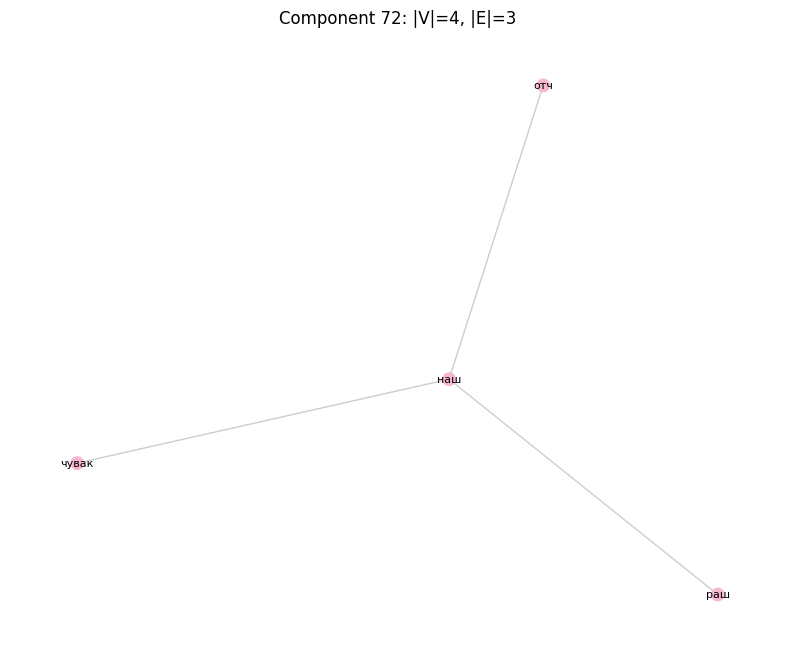

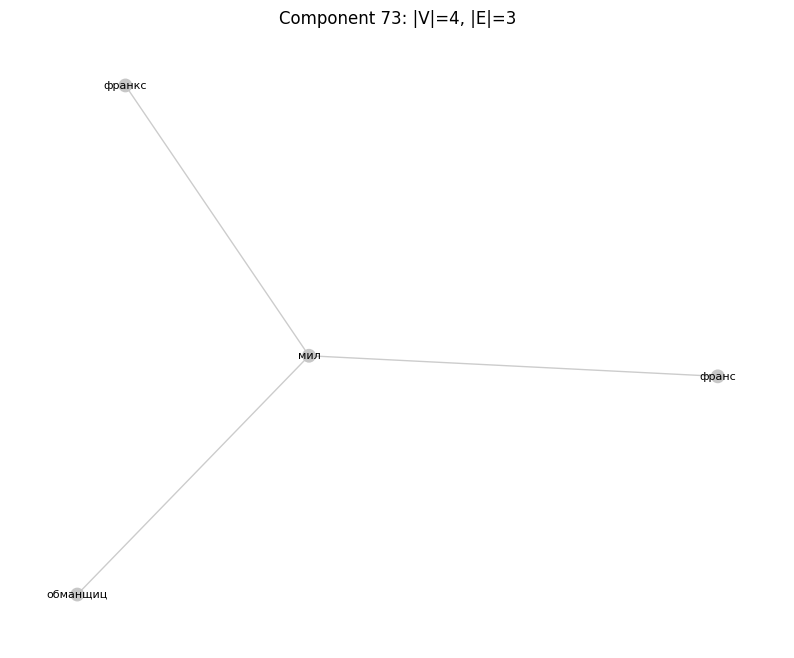

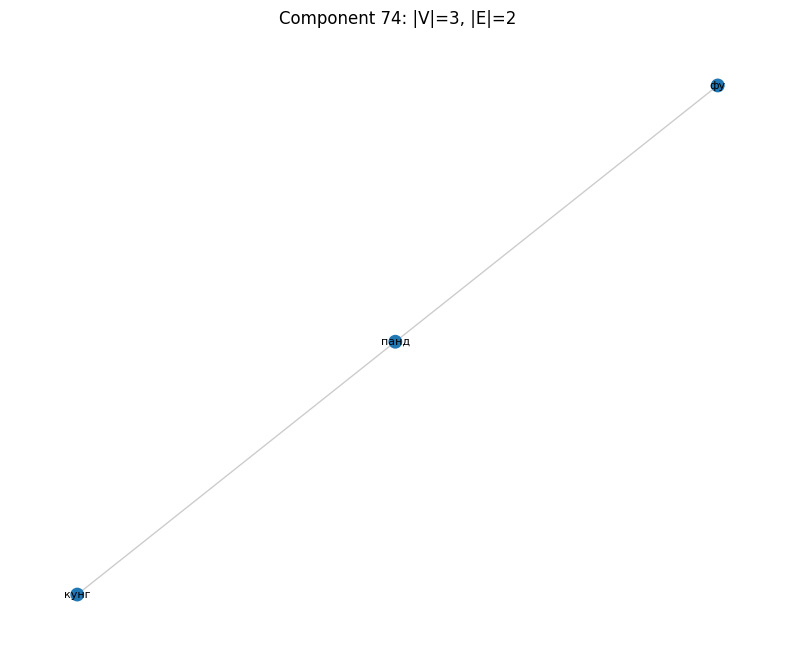

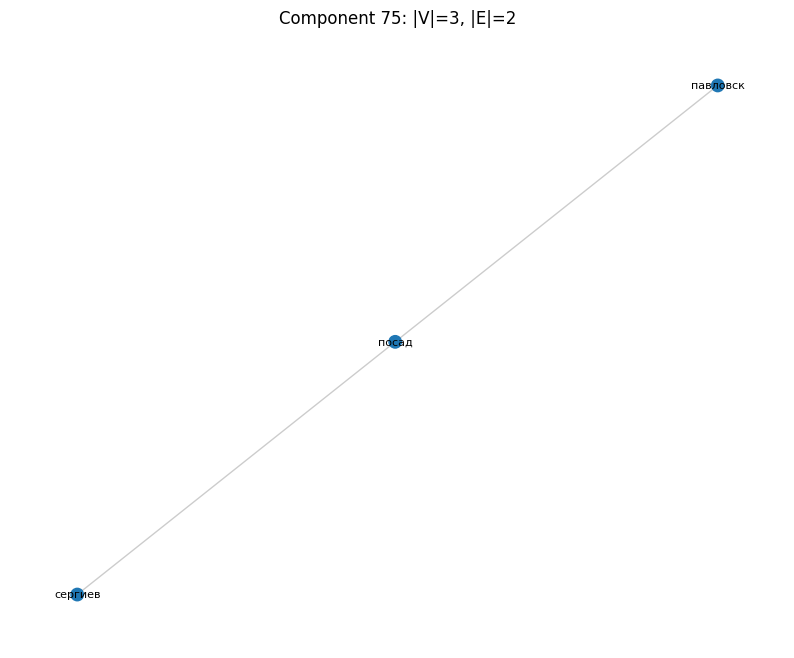

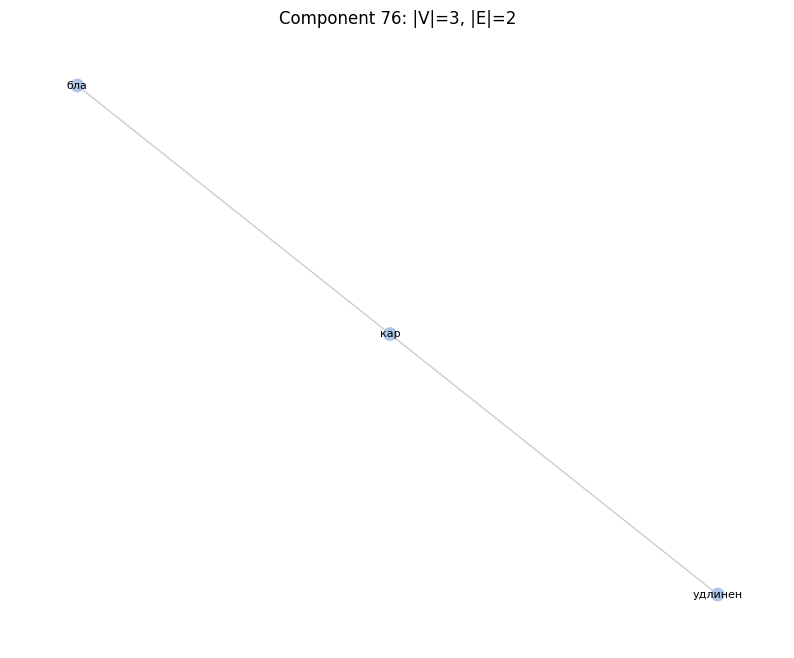

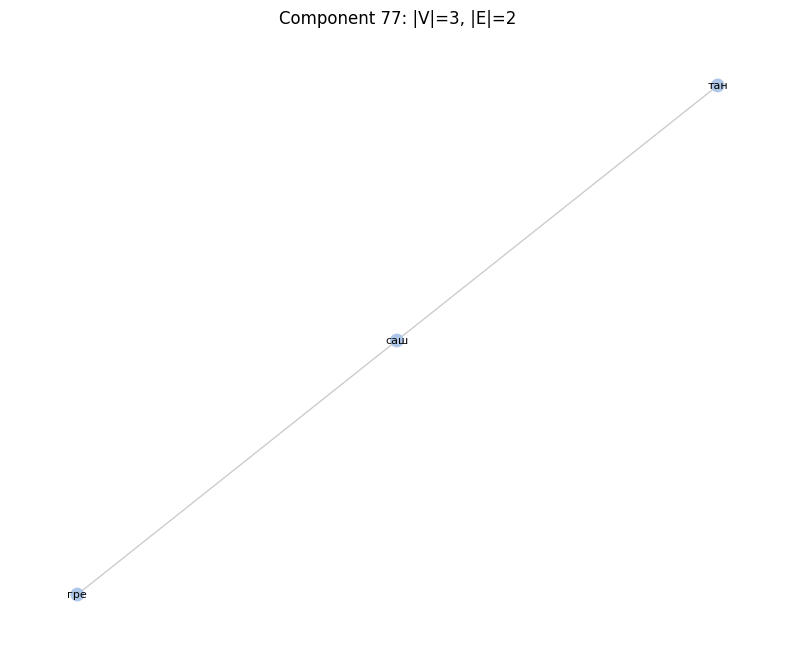

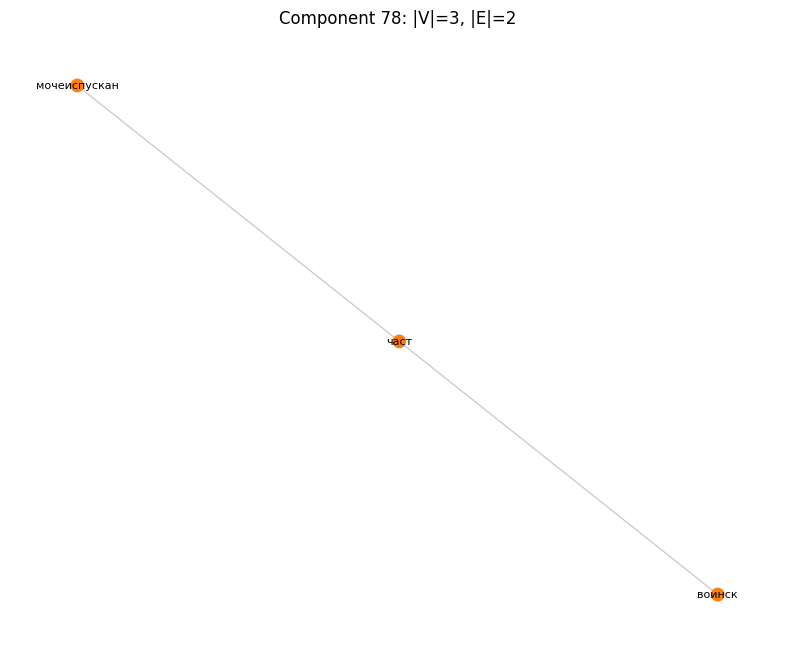

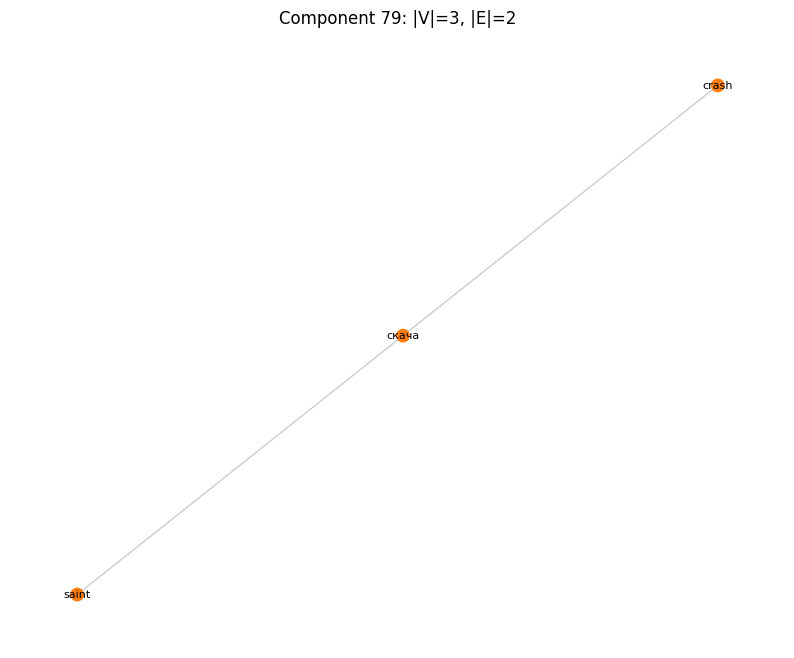

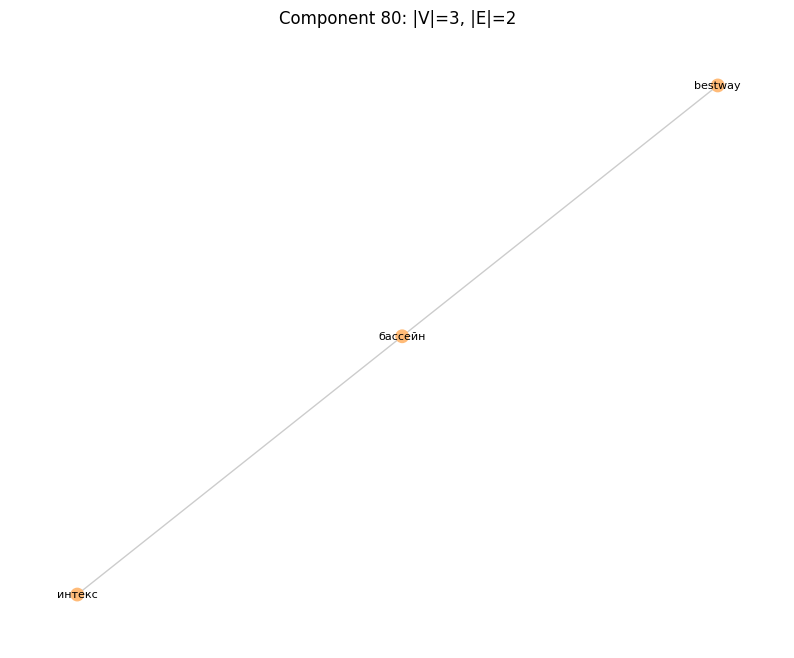

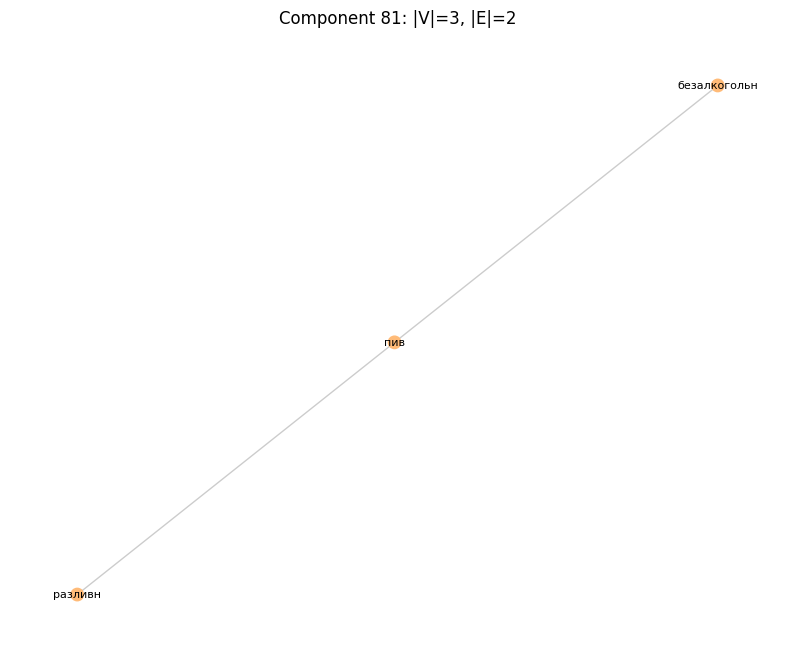

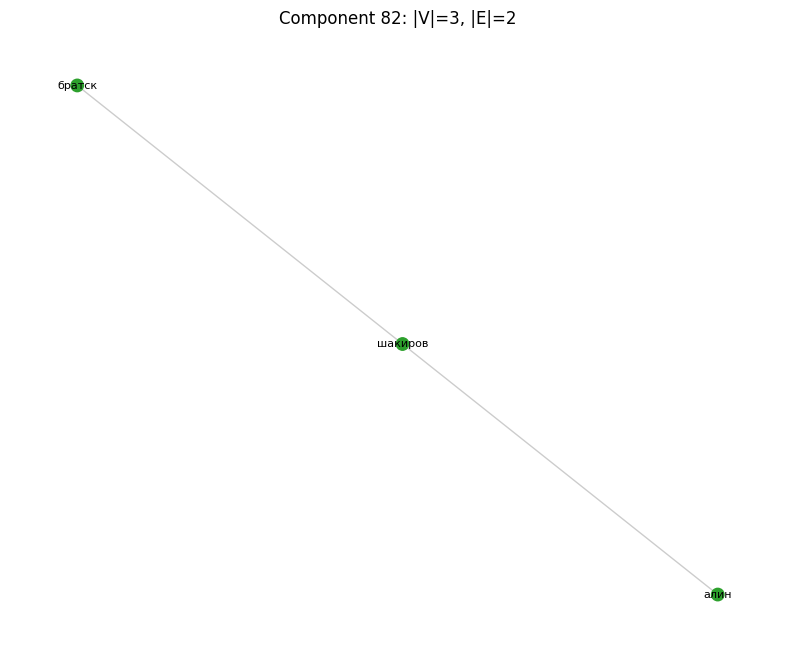

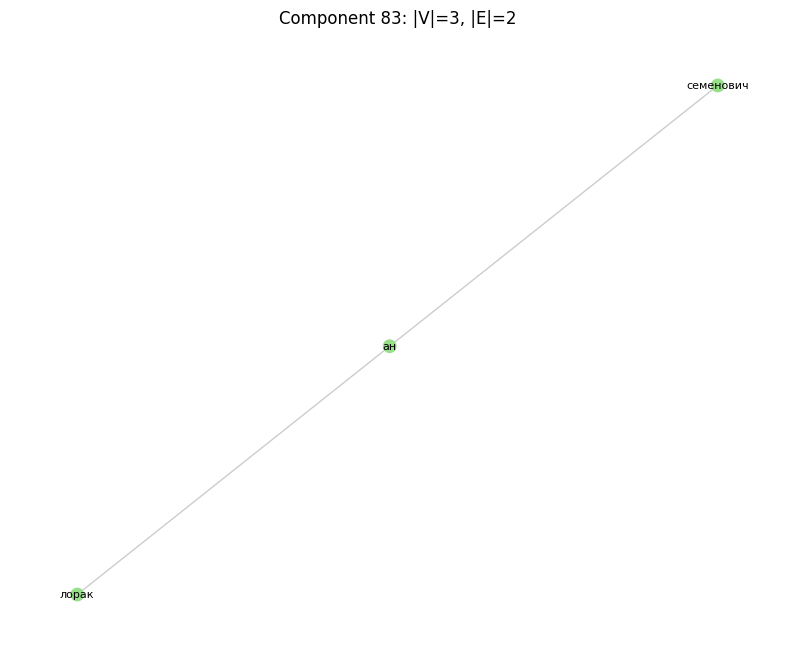

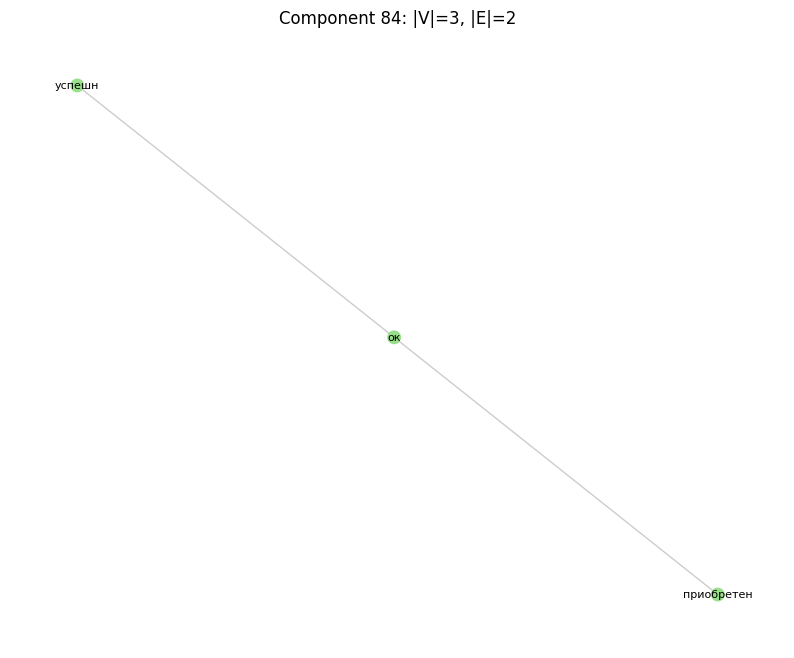

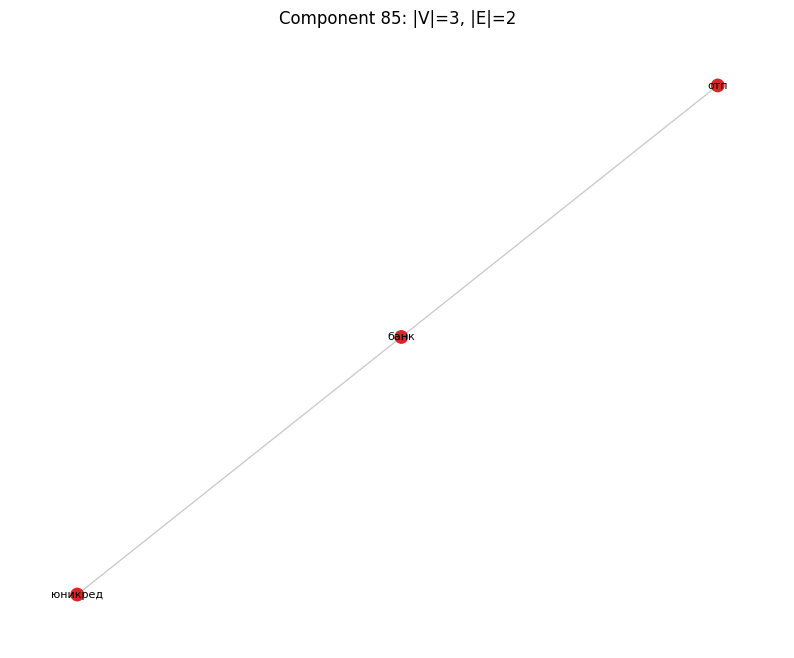

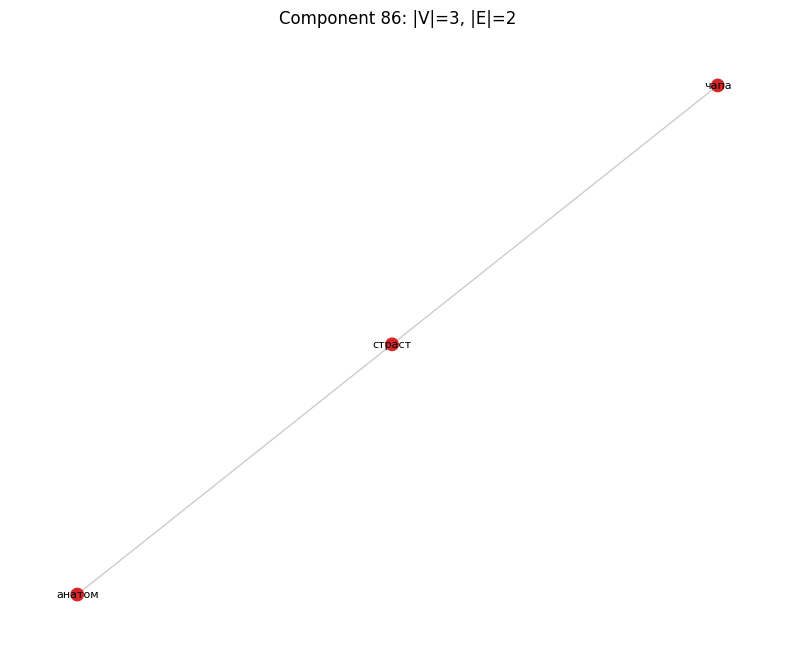

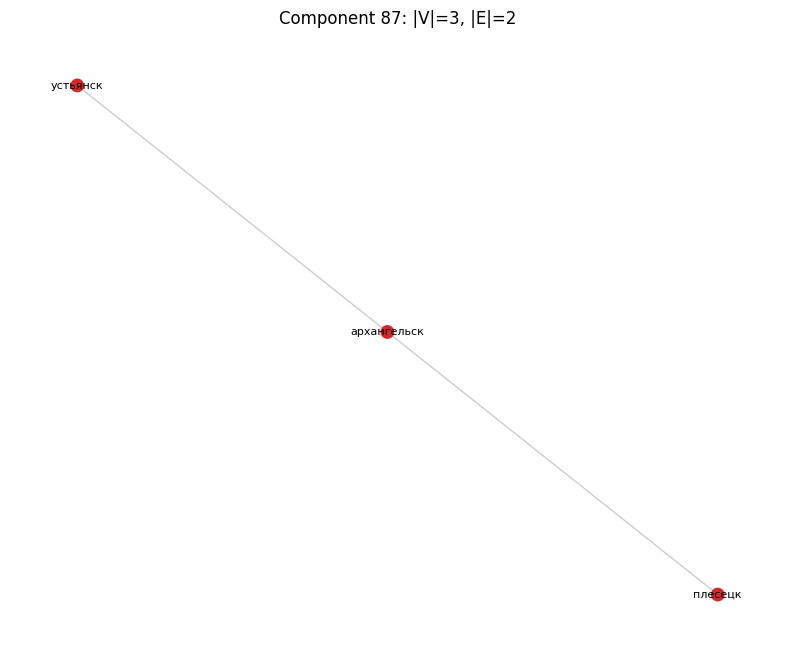

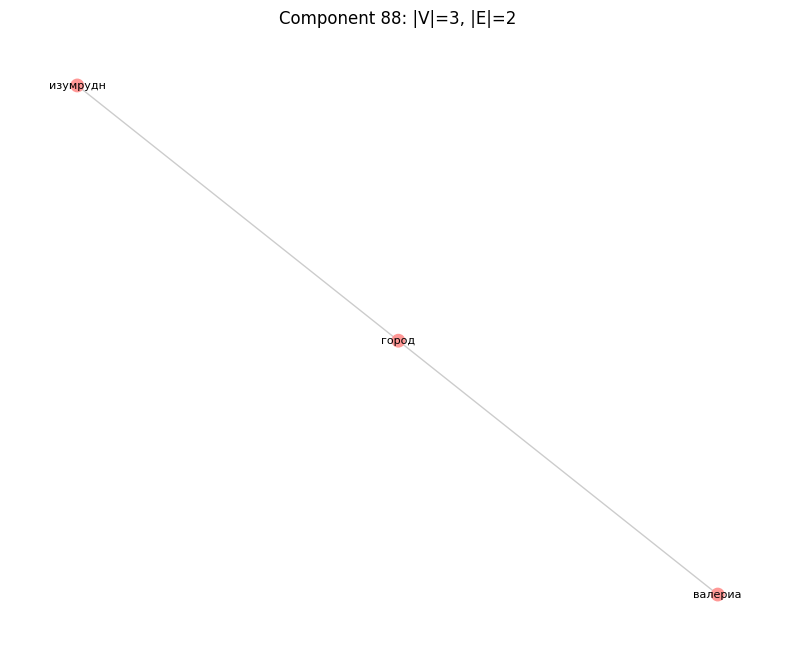

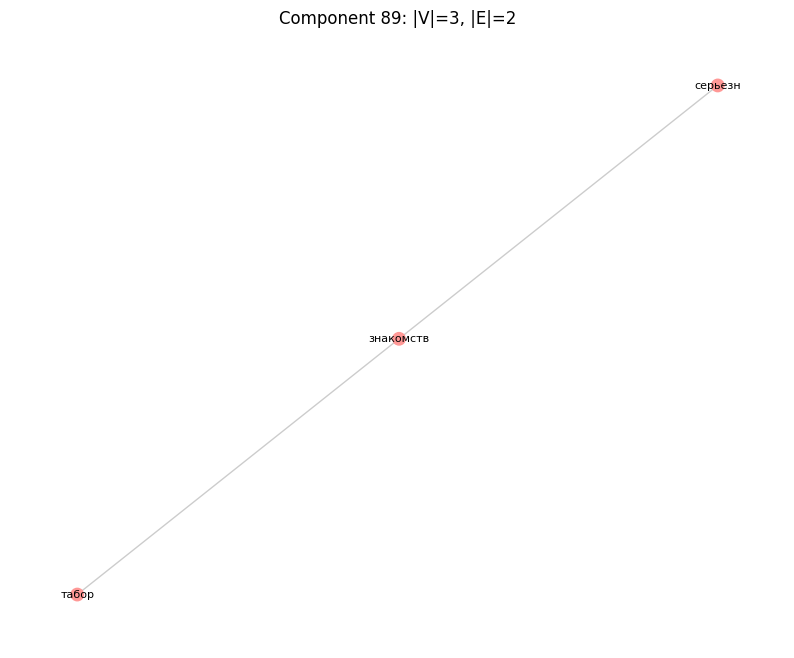

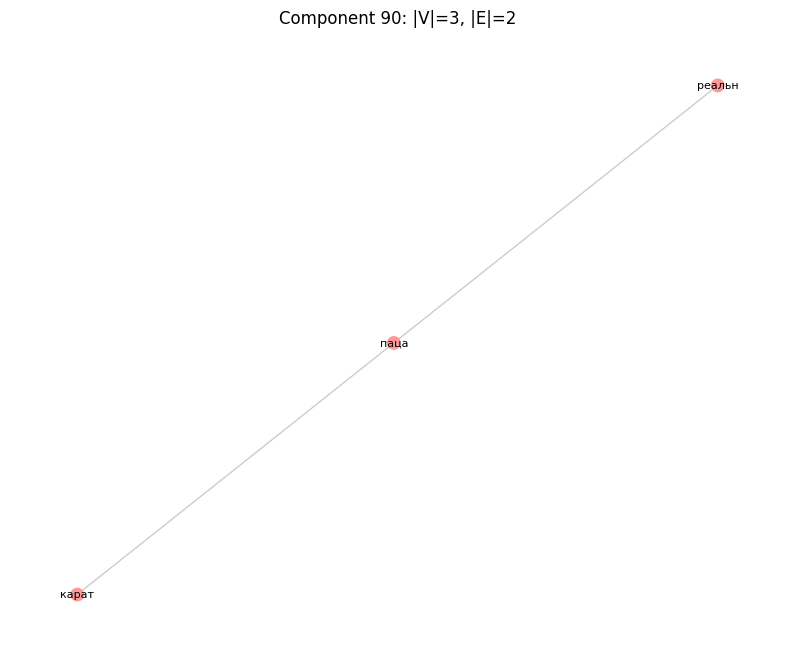

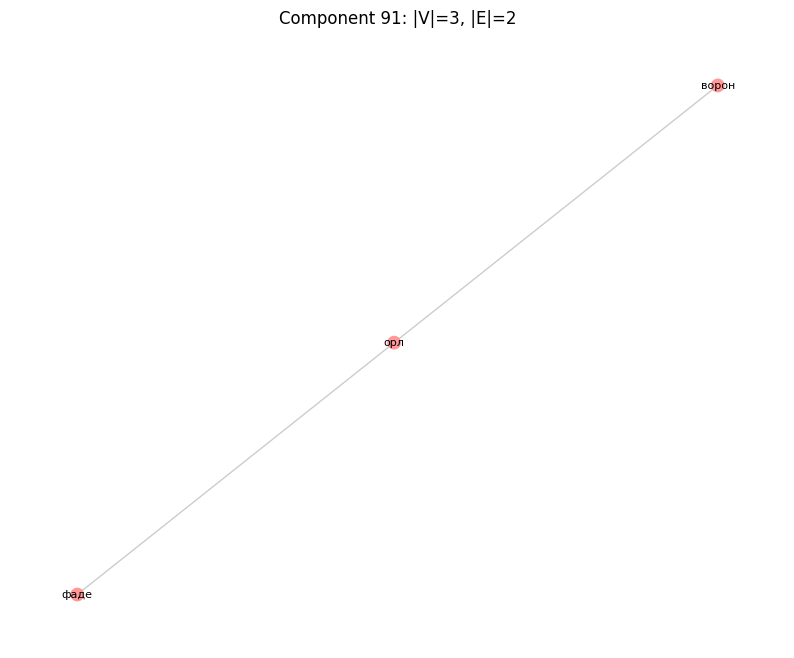

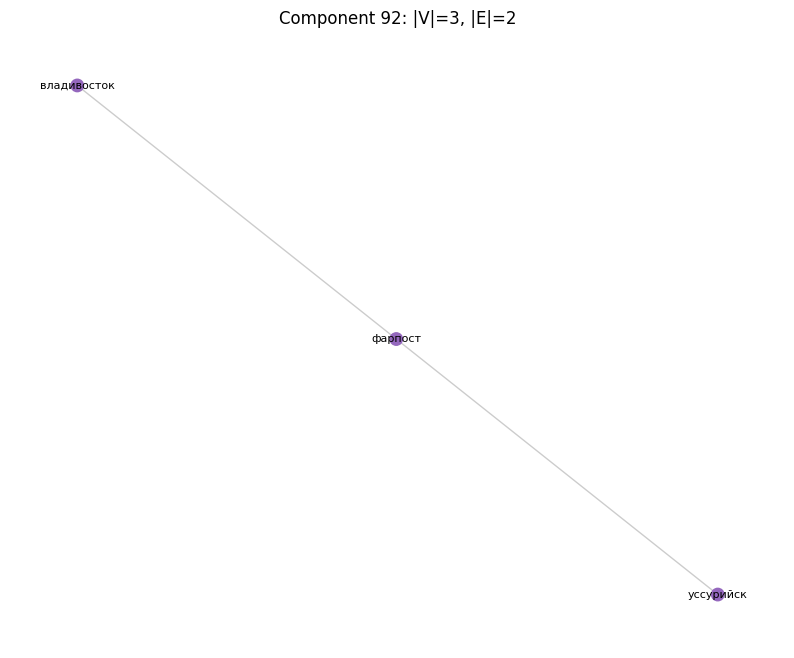

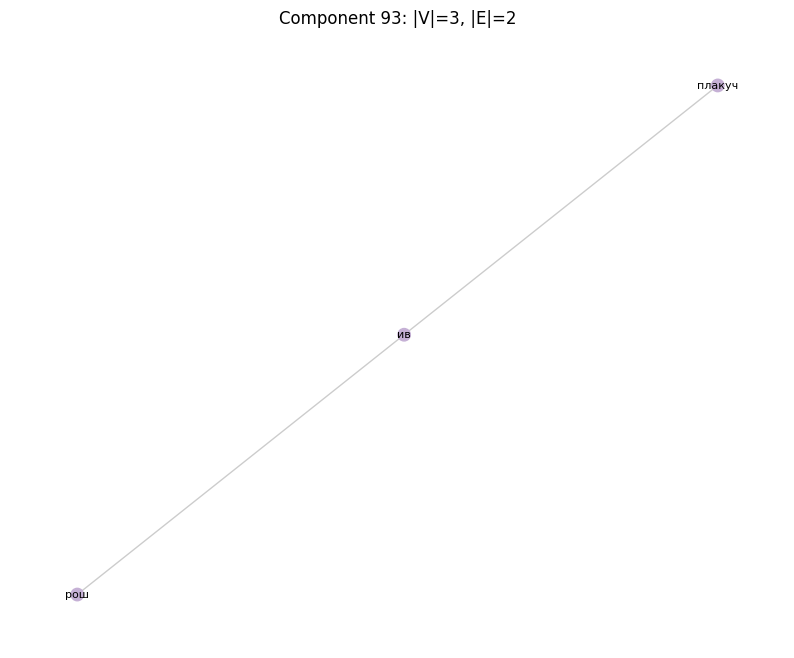

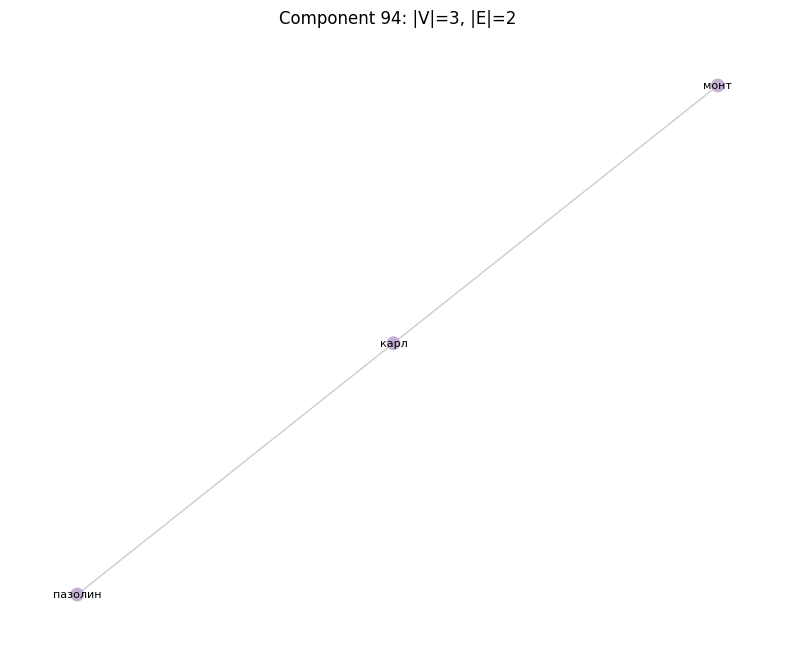

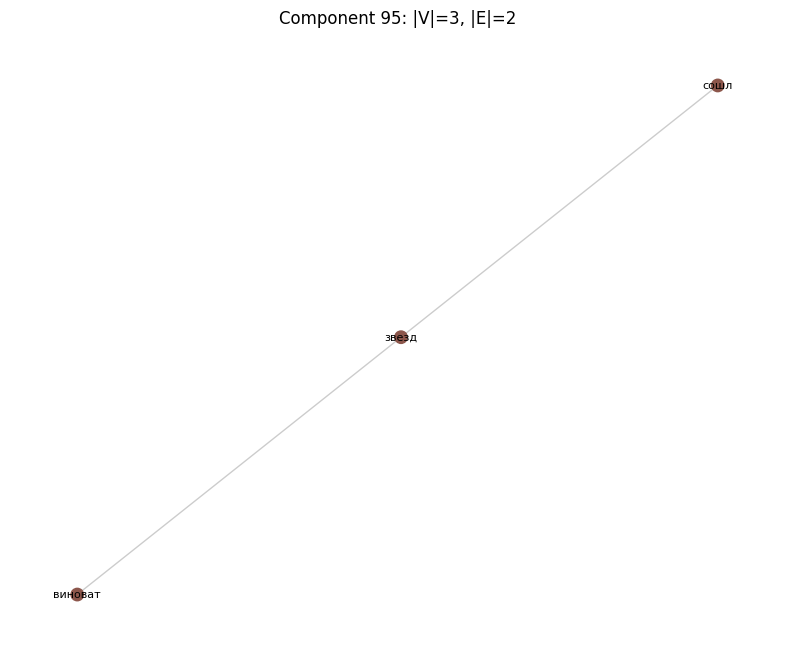

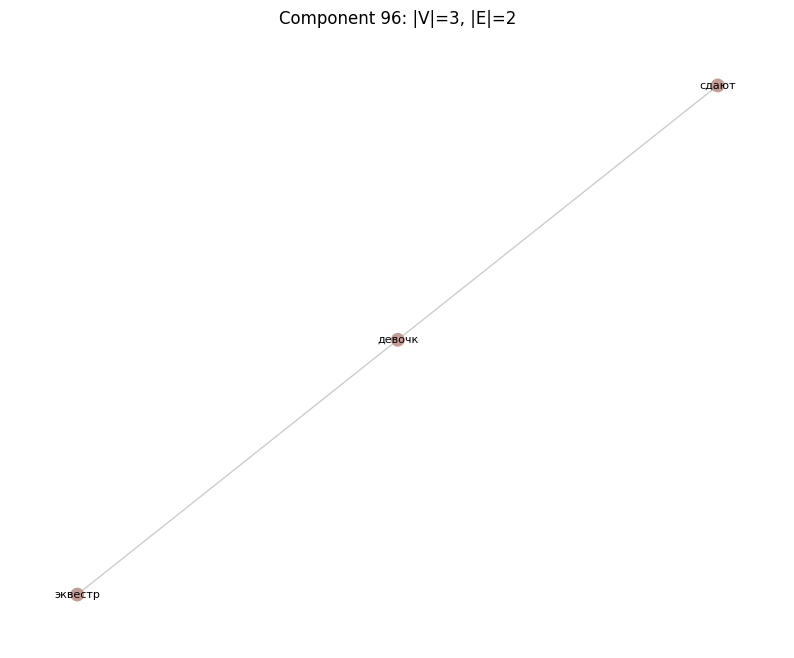

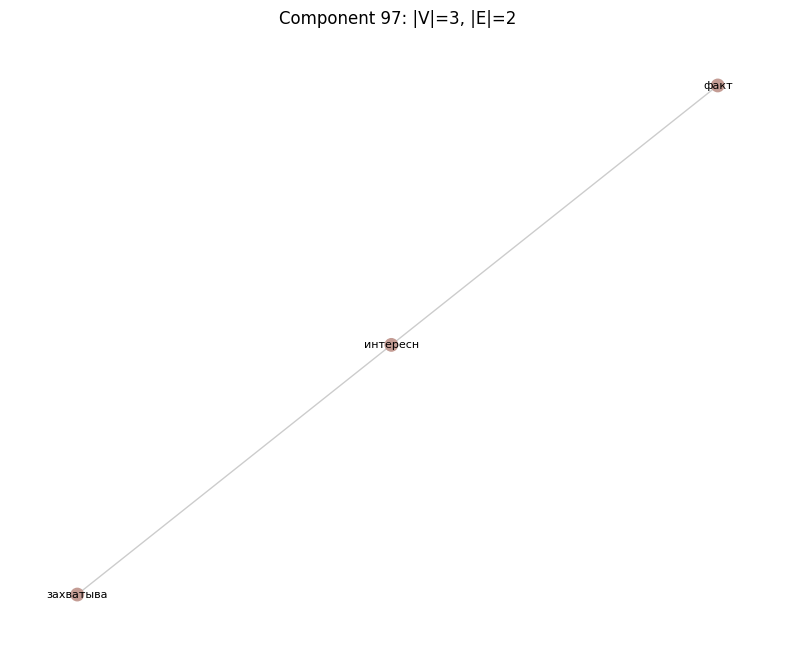

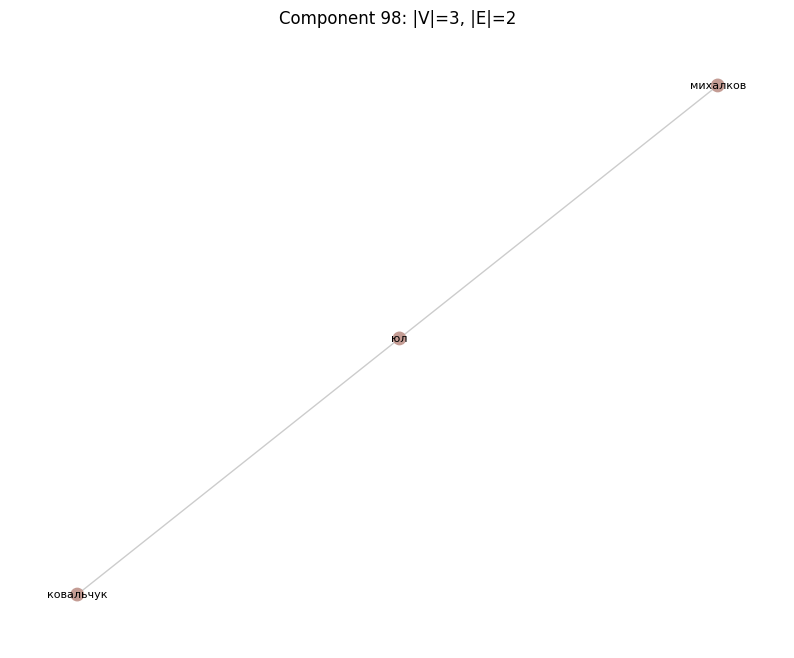

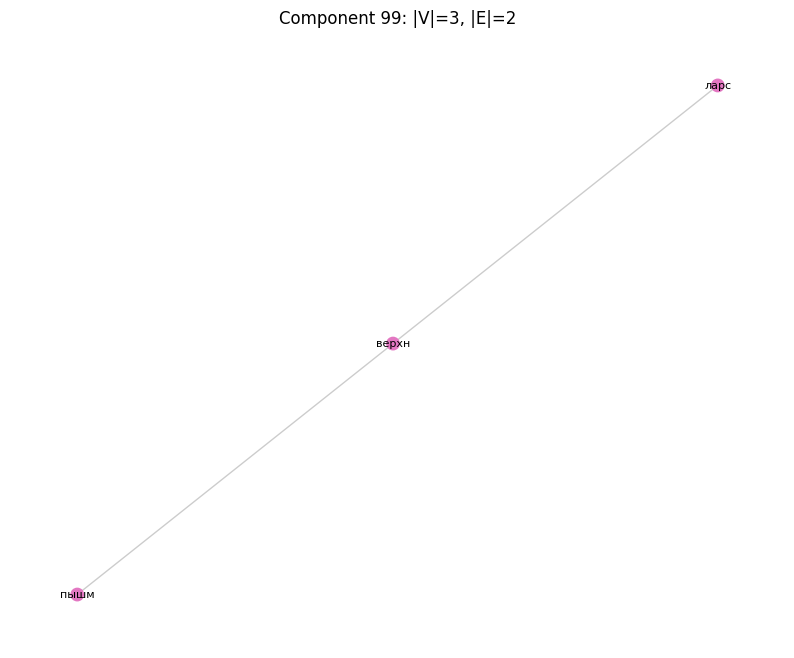

In [364]:
# Re-run community detection and visualization on G_core
if G_core.number_of_nodes() == 0:
    print("Core graph empty; consider lowering thresholds or k-core k")
else:
    try:
        import community as community_louvain
        partition_core = community_louvain.best_partition(G_core, weight="ppmi", resolution=RESOLUTION, random_state=RANDOM_STATE)
        algo = "louvain"
    except Exception:
        comms = list(nx.algorithms.community.greedy_modularity_communities(G_core, weight="ppmi"))
        partition_core = {}
        for cid, nodes in enumerate(comms):
            for n in nodes:
                partition_core[n] = cid
        algo = "greedy_modularity"

    num_clusters = len(set(partition_core.values())) if partition_core else 0
    print(f"Core communities: {num_clusters} (algo={algo}, resolution={RESOLUTION})")

    # Visualize connected components separately to avoid hairball
    from matplotlib import cm
    unique_cids = sorted(set(partition_core.values()))
    palette = cm.get_cmap('tab20', len(unique_cids))
    color_map = {cid: palette(i) for i, cid in enumerate(unique_cids)}

    for comp_id, comp_nodes in enumerate(sorted(nx.connected_components(G_core), key=len, reverse=True)[:TOP_N_CLUSTERS]):
        sub = G_core.subgraph(comp_nodes)
        pos = nx.spring_layout(sub, seed=RANDOM_STATE, weight='ppmi')
        plt.figure()
        nx.draw_networkx_edges(sub, pos, alpha=0.2)
        node_colors = [color_map[partition_core[n]] for n in sub.nodes()]
        nx.draw_networkx_nodes(sub, pos, node_color=node_colors, node_size=80)
        nx.draw_networkx_labels(sub, pos, font_size=8)
        plt.title(f"Component {comp_id}: |V|={sub.number_of_nodes()}, |E|={sub.number_of_edges()}")
        plt.axis('off')
        plt.savefig(f"graphs/core_component_{comp_id}.svg", format="svg", bbox_inches="tight")
        plt.show()


/var/folders/lw/f0n2qlq93lbgl6jfwf_6z7980000gn/T/ipykernel_6339/2282935014.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = cm.get_cmap('tab20', len(unique_cids))


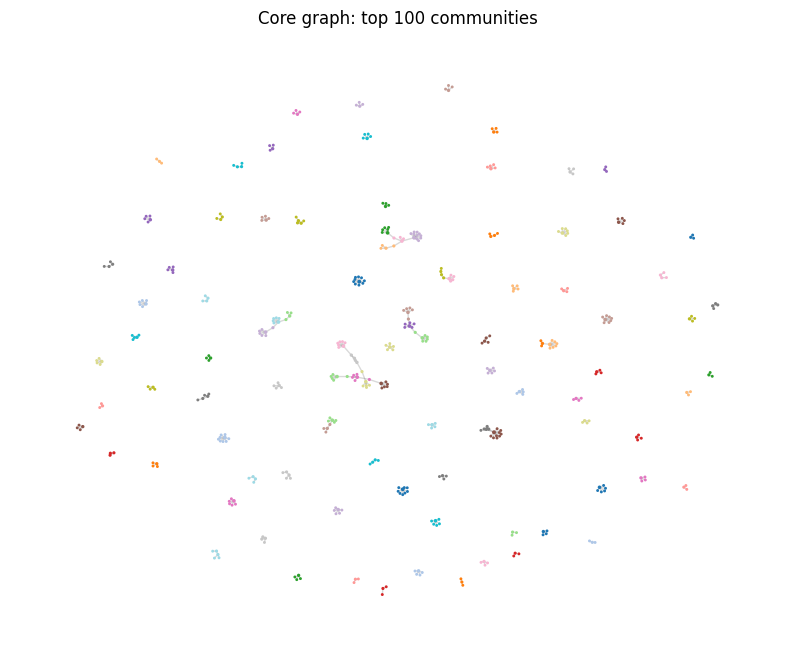

In [365]:
# Combined overview: TOP_N largest communities (by size) on one graph
if 'G_core' in globals() and 'partition_core' in globals() and G_core.number_of_nodes() > 0 and partition_core:
    from matplotlib import cm
    from collections import Counter

    # pick TOP_N_CLUSTERS largest community ids by size
    cid_sizes = Counter(partition_core.values())
    top_cids = [cid for cid, _ in cid_sizes.most_common(TOP_N_CLUSTERS)]

    # build subgraph with only nodes from those communities
    nodes_top = [n for n, cid in partition_core.items() if cid in top_cids]
    G_top = G_core.subgraph(nodes_top)

    unique_cids = sorted(top_cids)
    palette = cm.get_cmap('tab20', len(unique_cids))
    color_map = {cid: palette(i) for i, cid in enumerate(unique_cids)}

    pos = nx.spring_layout(G_top, seed=RANDOM_STATE, weight='ppmi')
    node_colors = [color_map[partition_core[n]] for n in G_top.nodes()]
    node_sizes = [3 + 2*math.log1p(G_top.degree(n)) for n in G_top.nodes()]

    plt.figure()
    nx.draw_networkx_edges(G_top, pos, alpha=0.15)
    nx.draw_networkx_nodes(G_top, pos, node_color=node_colors, node_size=node_sizes, linewidths=0)
    plt.title(f"Core graph: top {min(TOP_N_CLUSTERS, len(unique_cids))} communities")
    plt.axis('off')
    plt.savefig("graphs/top_core_overview.svg", format="svg", bbox_inches="tight")
    plt.show()
else:
    print("Core graph or partition not available; run the previous cells first")


/var/folders/lw/f0n2qlq93lbgl6jfwf_6z7980000gn/T/ipykernel_6339/3878021990.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = cm.get_cmap('tab20', len(unique_cids))


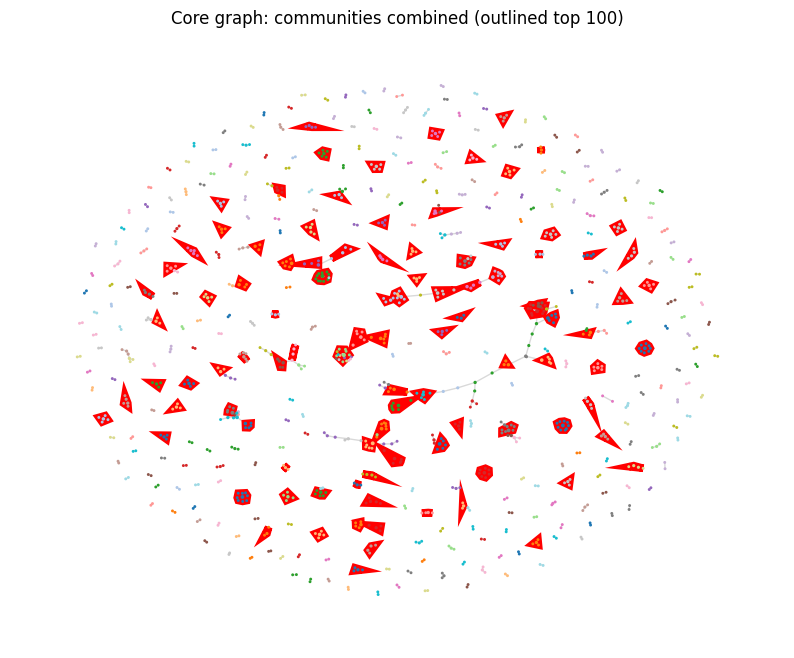

In [ ]:
# Combined overview: all core communities on one graph (with outlines for TOP_K largest)
if 'G_core' in globals() and 'partition_core' in globals() and G_core.number_of_nodes() > 0 and partition_core:
    from matplotlib import cm
    from matplotlib import patches
    from collections import Counter

    unique_cids = sorted(set(partition_core.values()))
    palette = cm.get_cmap('tab20', len(unique_cids))
    color_map = {cid: palette(i) for i, cid in enumerate(unique_cids)}

    # choose TOP_K largest communities to outline
    cid_sizes = Counter(partition_core.values())
    outline_cids = [cid for cid, _ in cid_sizes.most_common(TOP_N_CLUSTERS)]

    pos = nx.spring_layout(G_core, seed=RANDOM_STATE, weight='ppmi')
    node_colors = [color_map[partition_core[n]] for n in G_core.nodes()]
    node_sizes = [3 + 2*math.log1p(G_core.degree(n)) for n in G_core.nodes()]

    # helper: convex hull (Andrew's monotone chain)
    def convex_hull(points):
        points = sorted(set(points))
        if len(points) <= 2:
            return points
        def cross(o, a, b):
            return (a[0]-o[0])*(b[1]-o[1]) - (a[1]-o[1])*(b[0]-o[0])
        lower = []
        for p in points:
            while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
                lower.pop()
            lower.append(p)
        upper = []
        for p in reversed(points):
            while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
                upper.pop()
            upper.append(p)
        return lower[:-1] + upper[:-1]

    plt.figure()
    ax = plt.gca()
    nx.draw_networkx_edges(G_core, pos, alpha=0.15, ax=ax)
    nx.draw_networkx_nodes(G_core, pos, node_color=node_colors, node_size=node_sizes, linewidths=0, ax=ax)

    # draw outlines for TOP_N largest communities
    for cid in outline_cids:
        nodes_c = [n for n in G_core.nodes() if partition_core[n] == cid]
        pts = [(pos[n][0], pos[n][1]) for n in nodes_c if n in pos]
        if len(pts) >= 3:
            hull = convex_hull(pts)
            poly = patches.Polygon(hull, closed=True, fill=False, linewidth=3, edgecolor='red')
            ax.add_patch(poly)

    plt.title(f"Core graph: communities combined (outlined top {len(outline_cids)})")
    plt.axis('off')
    plt.savefig("graphs/core_overview.svg", format="svg", bbox_inches="tight")
    plt.show()
else:
    print("Core graph or partition not available; run the previous cells first")
